# DS7333 Case Study 1
## Predicting the Critical Temperature of Various Superconductors Utilizing Regression Models

#### John Girard, Shijo Joseph, Douglas Yip

Installing and setting up flake8 

In [1]:
# if you do not have flake8 installed
# then uncomment the pip line below and run it.

# pip install flake8 pycodestyle_magic

In [2]:
%load_ext pycodestyle_magic
%pycodestyle_on

#### Objective

We have been tasked with creating a linear regression model to predict critical temperature of various super conductors.  We will also examine which variables are most important in our model.

In [3]:
# Importing Libraries that will be used to
# ingest data and complete our regression
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model \
    import Lasso, LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection \
    import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor
from statistics import mean


get_ipython().run_line_magic('matplotlib', 'inline')

## 1) Import and Check data
This process will ingest the data into one dataframe and will validate integrity of data before proceeding to EDA

In [4]:
# Import data
path = 'https://raw.githubusercontent.com/dk28yip/MSDS7333/main/'
unique_f = path + 'unique_m.csv'
train_f = path + 'train.csv'
df1 = pd.read_csv(unique_f)
df2 = pd.read_csv(train_f)

# drop critical temp since column exist in both sets
df1 = df1.drop(['critical_temp'], axis=1)

# Merge the two data frames
df = pd.concat([df1, df2], axis=1)

In [5]:
# check dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 169 entries, H to critical_temp
dtypes: float64(156), int64(12), object(1)
memory usage: 27.4+ MB


H  He   Li   Be    B    C    N    O    F  Ne  ...  wtd_mean_Valence  \
0  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.257143   
1  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.257143   
2  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.271429   
3  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.264286   
4  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.242857   

   gmean_Valence  wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  \
0       2.213364           2.219783         1.368922             1.066221   
1       1.888175           2.210679         1.557113             1.047221   
2       2.213364           2.232679         1.368922             1.029175   
3       2.213364           2.226222         1.368922             1.048834   
4       2.213364           2.206963         1.368922             1.096052   

   range_Valence  wtd_range_Valence  std_Valence  wtd_std_Valence  \
0              1           1.085714     0.433013         0.437059   
1              2           1.128571     0.632456         0.468606   
2              1           1.114286     0.433013         0.444697   
3              1           1.100000     0.433013         0.440952   
4              1           1.057143     0.433013         0.428809   

   critical_temp  
0           29.0  
1           26.0  
2           19.0  
3           22.0  
4           23.0  

[5 rows x 169 columns]

In [6]:
# Examine the shape of the data
df.shape

(21263, 169)

#### Dropped material column due to redudancy of data given that the invididual elements are showing in the data.  

In [7]:
df = df.drop(['material'], axis=1)

In [8]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame = df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100, 1)
    nan_df['Type'] = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i, 'Column'],
                                    df.shape[0]
                                    - nan_df.loc[i, 'NaN_Count'], 100
                                    - nan_df.loc[i, 'NaN_%'],
                                    'Completeness']).T
        complete_df.columns = ['Column', 'NaN_Count', 'NaN_%', 'Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df, complete_df], sort=True)
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df, x='Feature', y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type', opacity=0.6,
                 color_discrete_sequence=['red', '#808080'],
                 width=800, height=400)
    fig.show()

In [9]:
plot_missingness(df)

#### Based on our missing NA check, there are no NAs in the data.

In [10]:
# Print the column names
for col_names in df.columns:
    print(col_names)

H
He
Li
Be
B
C
N
O
F
Ne
Na
Mg
Al
Si
P
S
Cl
Ar
K
Ca
Sc
Ti
V
Cr
Mn
Fe
Co
Ni
Cu
Zn
Ga
Ge
As
Se
Br
Kr
Rb
Sr
Y
Zr
Nb
Mo
Tc
Ru
Rh
Pd
Ag
Cd
In
Sn
Sb
Te
I
Xe
Cs
Ba
La
Ce
Pr
Nd
Pm
Sm
Eu
Gd
Tb
Dy
Ho
Er
Tm
Yb
Lu
Hf
Ta
W
Re
Os
Ir
Pt
Au
Hg
Tl
Pb
Bi
Po
At
Rn
number_of_elements
mean_atomic_mass
wtd_mean_atomic_mass
gmean_atomic_mass
wtd_gmean_atomic_mass
entropy_atomic_mass
wtd_entropy_atomic_mass
range_atomic_mass
wtd_range_atomic_mass
std_atomic_mass
wtd_std_atomic_mass
mean_fie
wtd_mean_fie
gmean_fie
wtd_gmean_fie
entropy_fie
wtd_entropy_fie
range_fie
wtd_range_fie
std_fie
wtd_std_fie
mean_atomic_radius
wtd_mean_atomic_radius
gmean_atomic_radius
wtd_gmean_atomic_radius
entropy_atomic_radius
wtd_entropy_atomic_radius
range_atomic_radius
wtd_range_atomic_radius
std_atomic_radius
wtd_std_atomic_radius
mean_Density
wtd_mean_Density
gmean_Density
wtd_gmean_Density
entropy_Density
wtd_entropy_Density
range_Density
wtd_range_Density
std_Density
wtd_std_Density
mean_ElectronAffinity
wtd_mean_ElectronAffin

In [11]:
# Examine the column names and data types
pd.set_option('display.max_rows', None)
df.describe().T

count         mean          std  \
H                                21263.0     0.017685     0.267220   
He                               21263.0     0.000000     0.000000   
Li                               21263.0     0.012125     0.129552   
Be                               21263.0     0.034638     0.848541   
B                                21263.0     0.142594     1.044486   
C                                21263.0     0.384968     4.408032   
N                                21263.0     0.013284     0.150427   
O                                21263.0     3.009129     3.811649   
F                                21263.0     0.014874     0.132119   
Ne                               21263.0     0.000000     0.000000   
Na                               21263.0     0.008892     0.101685   
Mg                               21263.0     0.026772     0.271606   
Al                               21263.0     0.061678     1.126254   
Si                               21263.0     0.189889     2.217277   
P                                21263.0     0.028143     0.466710   
S                                21263.0     0.106246     0.760821   
Cl                               21263.0     0.009050     0.119717   
Ar                               21263.0     0.000000     0.000000   
K                                21263.0     0.016042     0.138187   
Ca                               21263.0     0.258347     0.902732   
Sc                               21263.0     0.010919     0.185651   
Ti                               21263.0     0.156817     2.728139   
V                                21263.0     0.224782     3.407763   
Cr                               21263.0     0.006119     0.254272   
Mn                               21263.0     0.003191     0.129449   
Fe                               21263.0     0.153182     0.713075   
Co                               21263.0     0.035323     0.580672   
Ni                               21263.0     0.090182     0.982521   
Cu                               21263.0     1.276751     2.079375   
Zn                               21263.0     0.014034     0.403316   
Ga                               21263.0     0.073997     1.115005   
Ge                               21263.0     0.082556     1.021279   
As                               21263.0     0.155197     1.076049   
Se                               21263.0     0.078662     0.676294   
Br                               21263.0     0.003940     0.083907   
Kr                               21263.0     0.000000     0.000000   
Rb                               21263.0     0.007799     0.121254   
Sr                               21263.0     0.326909     0.763625   
Y                                21263.0     0.177556     0.429953   
Zr                               21263.0     0.370901     4.846459   
Nb                               21263.0     0.442349     4.848246   
Mo                               21263.0     0.146367     2.084302   
Tc                               21263.0     0.002291     0.064728   
Ru                               21263.0     0.055325     0.770327   
Rh                               21263.0     0.068072     1.005898   
Pd                               21263.0     0.085034     1.554018   
Ag                               21263.0     0.007834     0.167831   
Cd                               21263.0     0.009152     0.688729   
In                               21263.0     0.049468     0.521820   
Sn                               21263.0     0.120994     1.886951   
Sb                               21263.0     0.101269     1.839020   
Te                               21263.0     0.040491     0.718043   
I                                21263.0     0.004744     0.088480   
Xe                               21263.0     0.000000     0.000000   
Cs                               21263.0     0.004129     0.077676   
Ba                               21263.0     0.568440     0.983288   
La                               21263.0     

## 2) Scale data
Given that the box plot shows a wide range of variance between columns we will scale the data

In [12]:
# Create the response and dependent variable sets
X = df.drop(labels=['critical_temp'], axis=1)
y = df.critical_temp


scaler = StandardScaler()  # Create the standard scaler object

# Fit the data and transform it, leaving an array
X_scaled = scaler.fit_transform(X)

# Recreate the dataframe
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

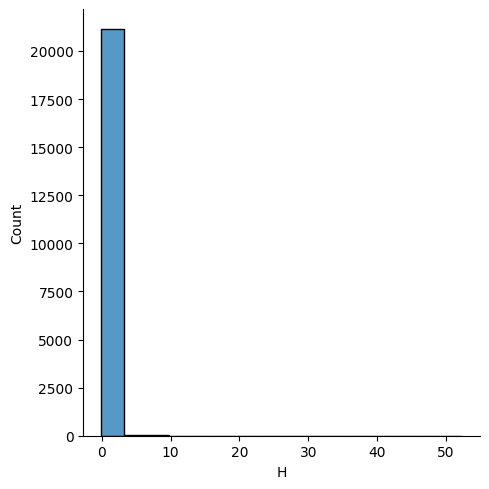

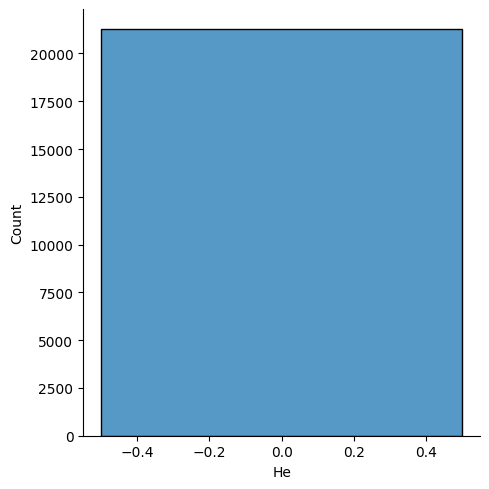

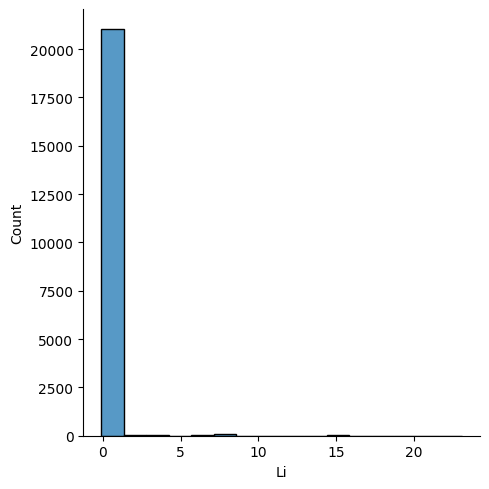

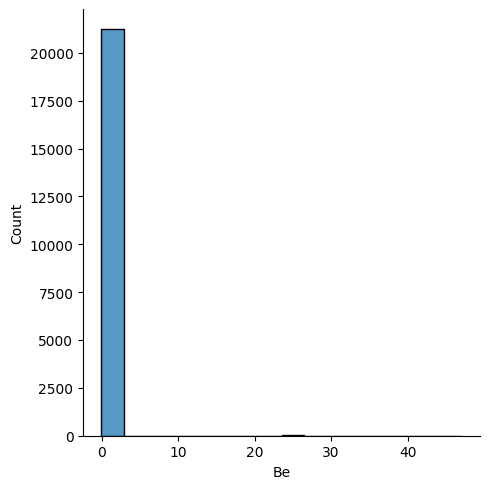

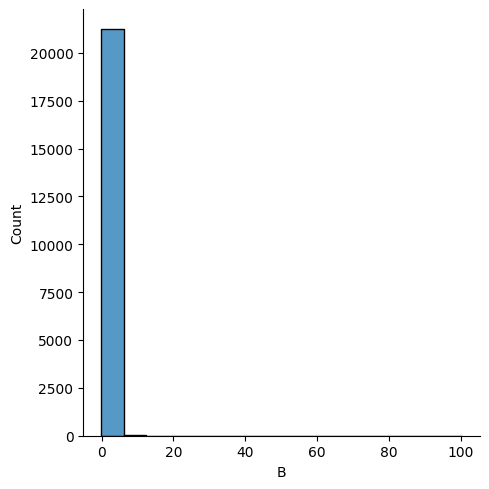

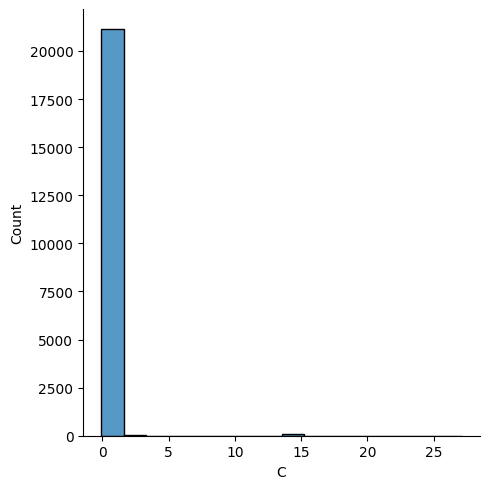

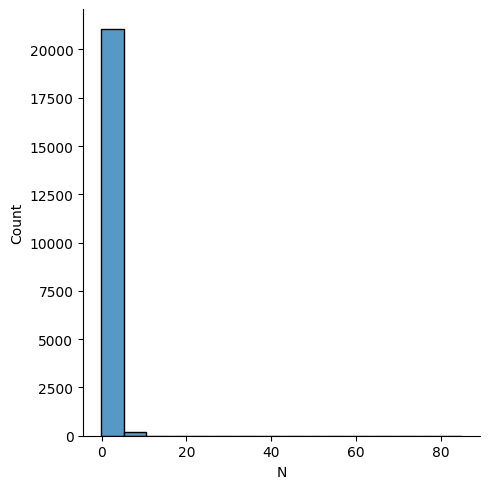

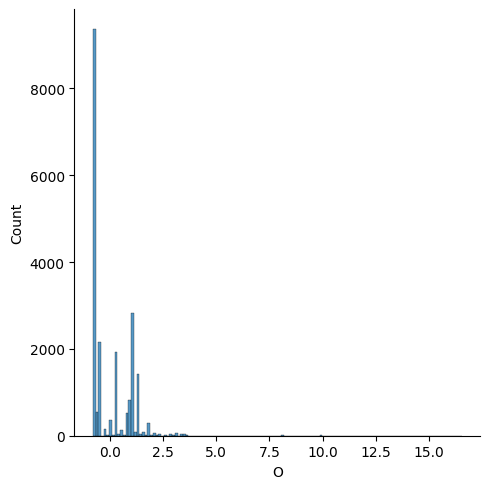

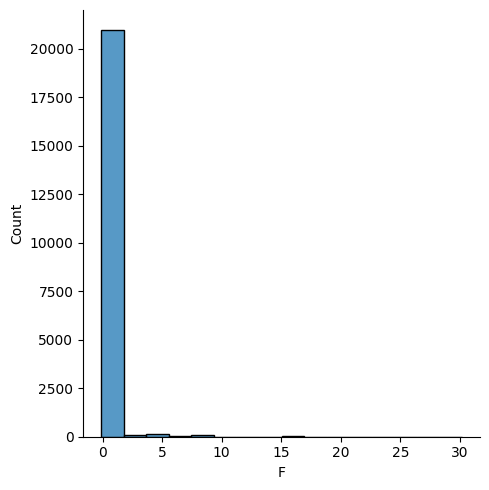

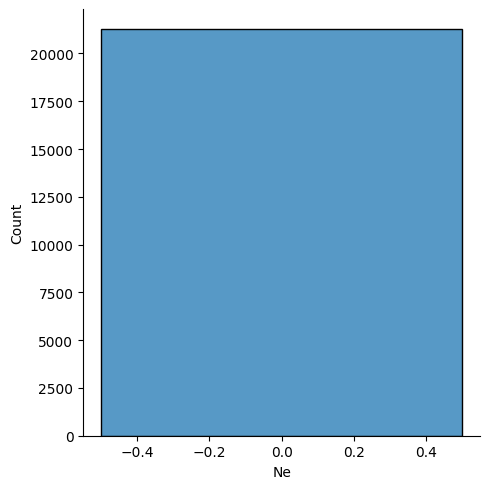

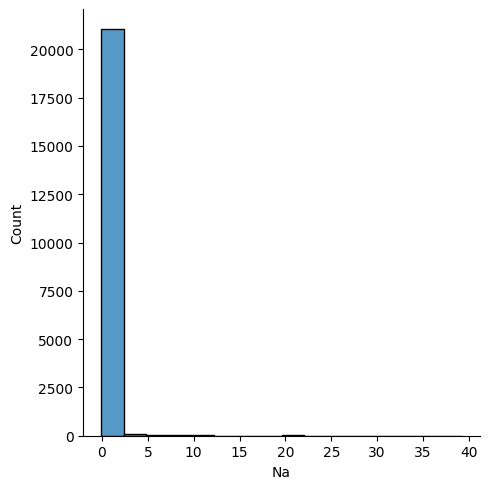

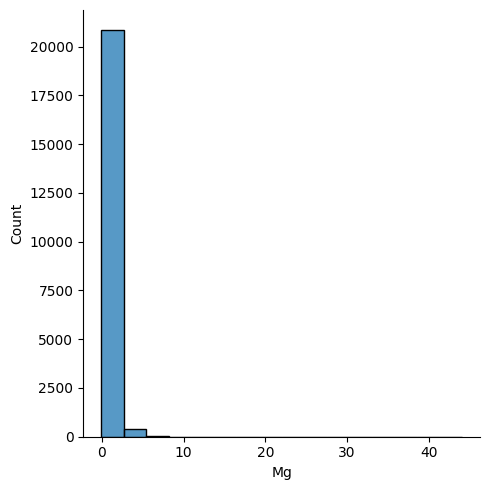

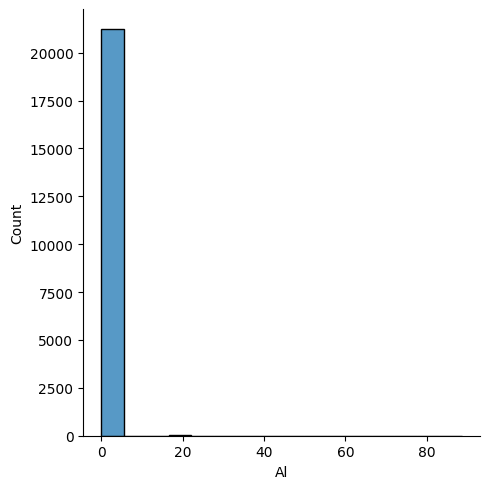

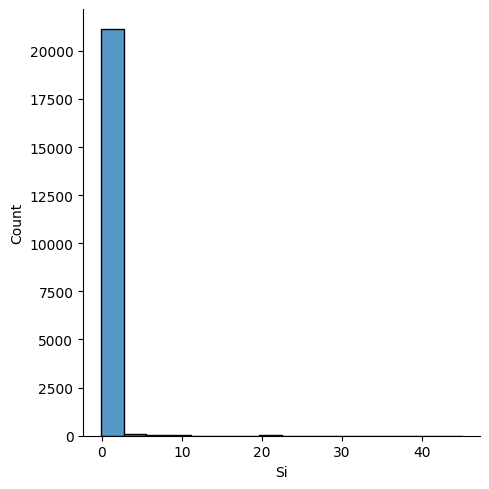

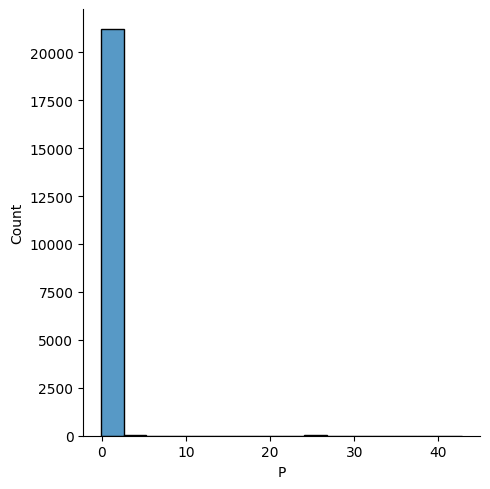

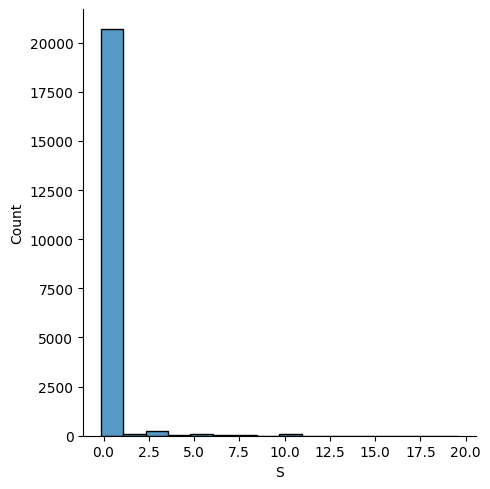

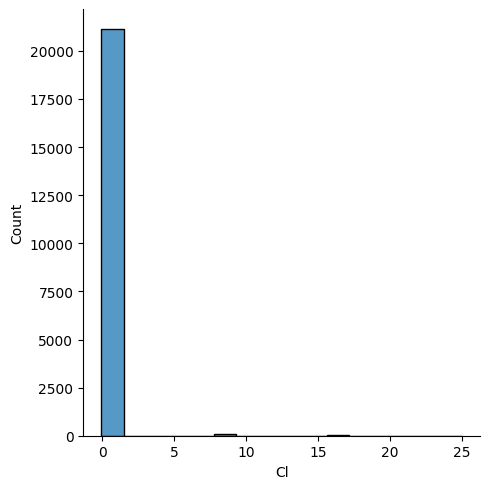

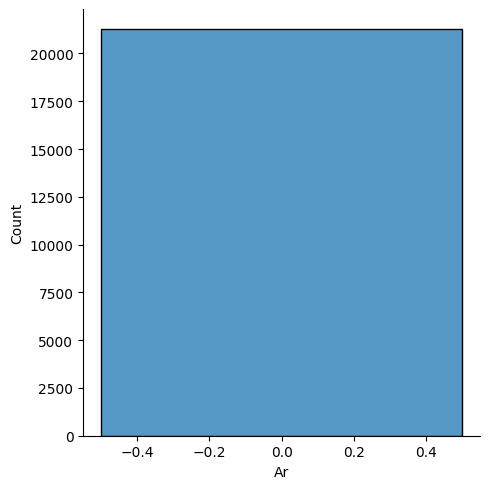

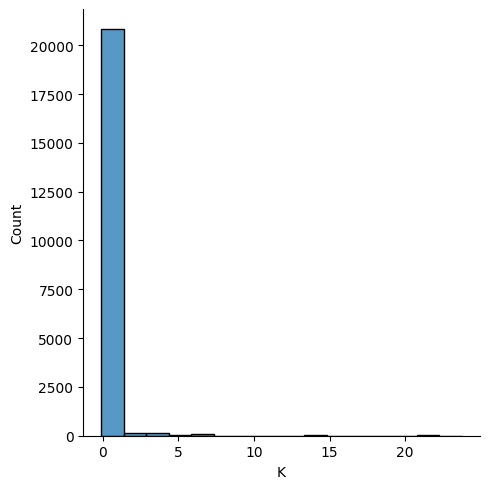

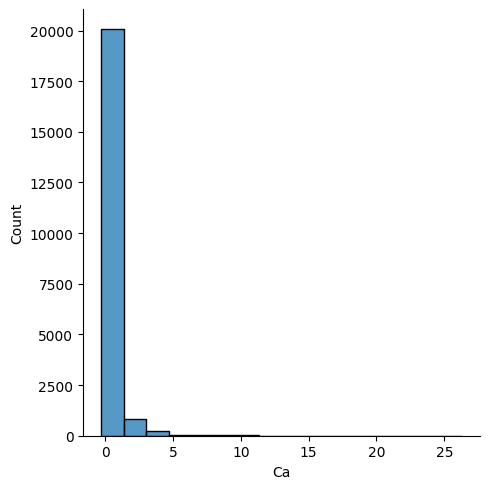

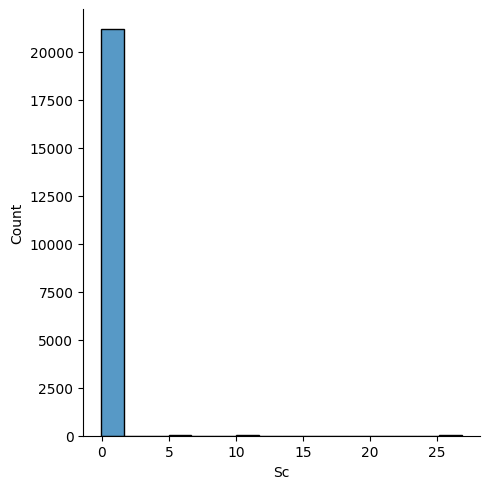

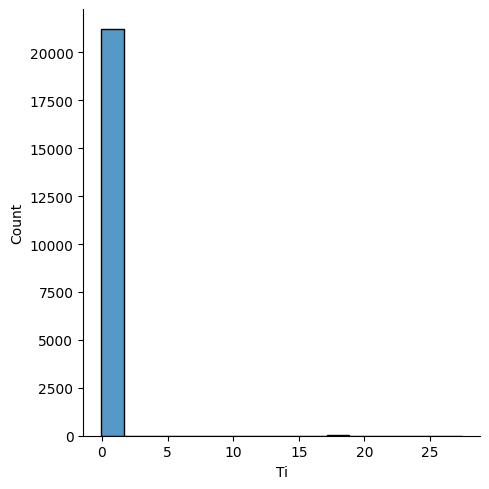

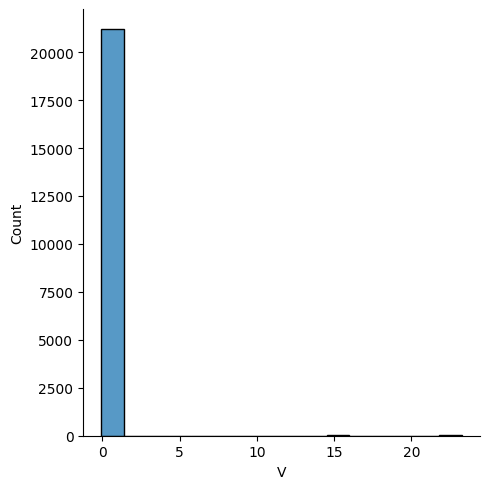

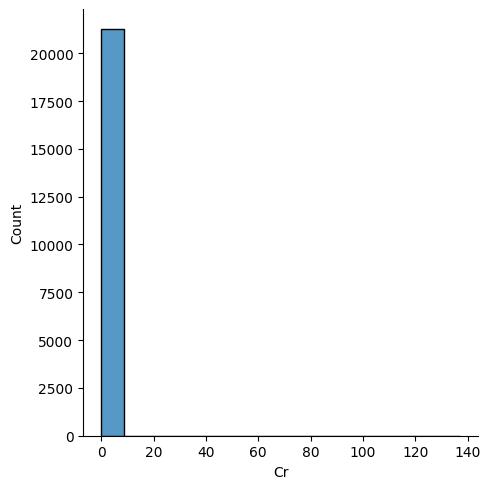

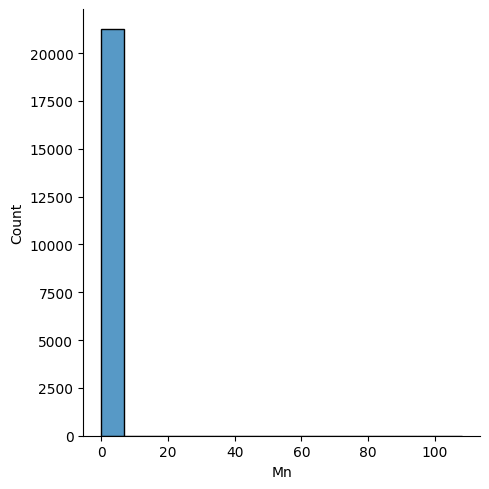

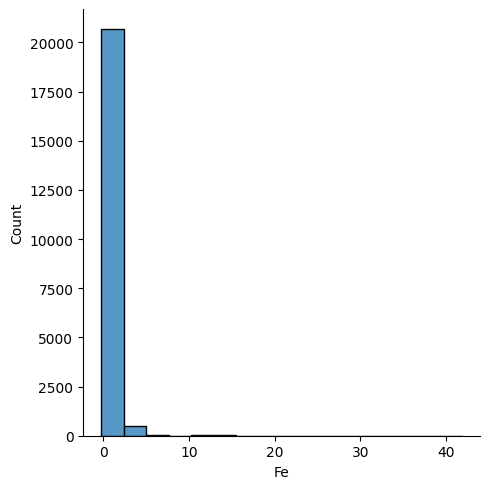

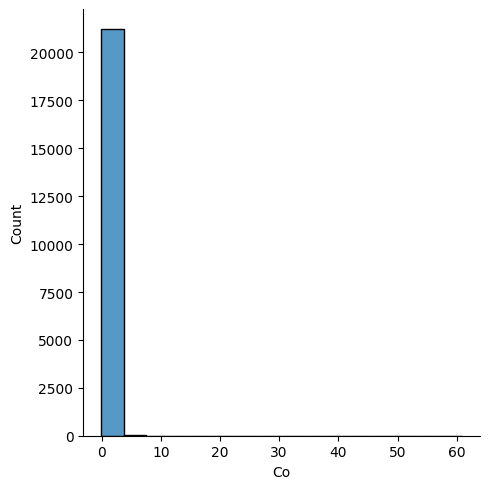

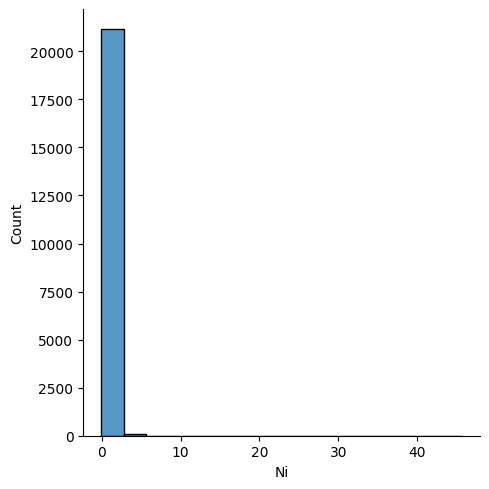

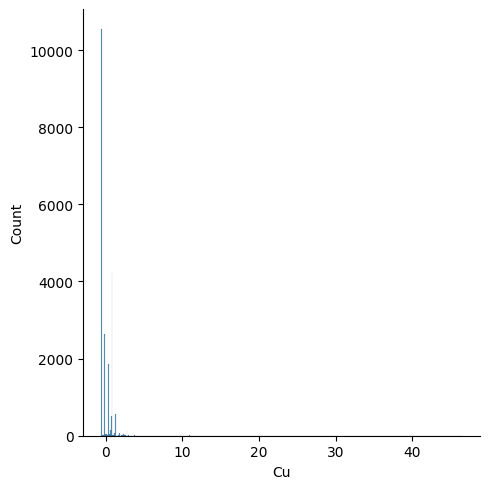

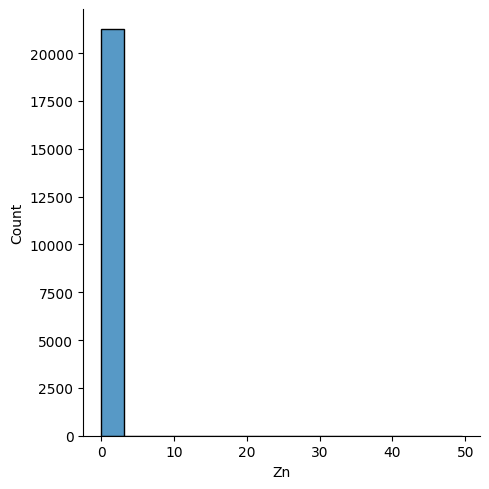

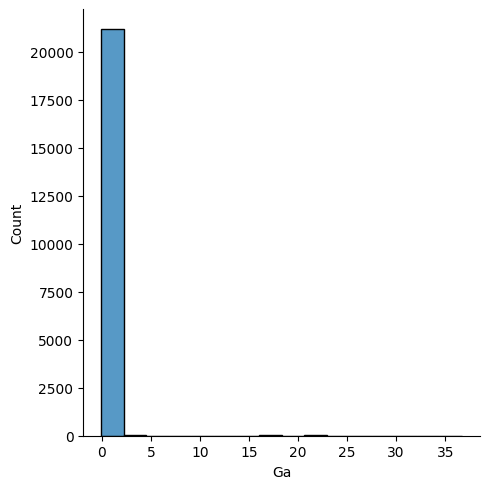

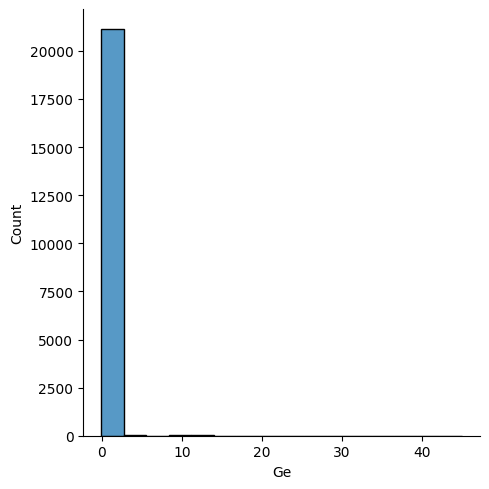

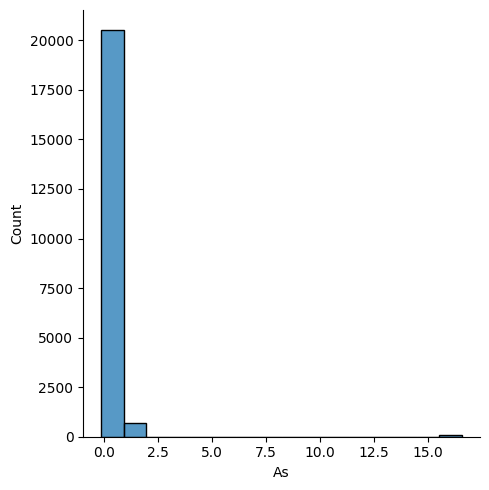

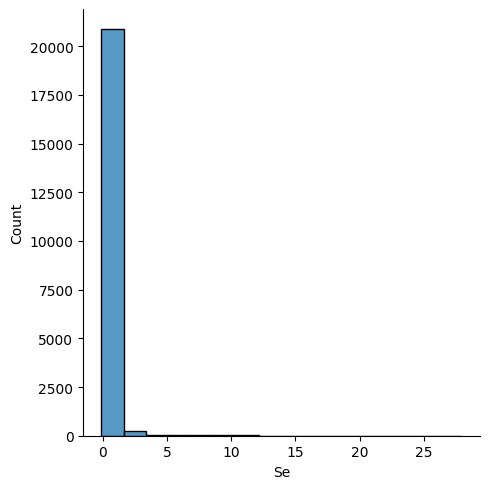

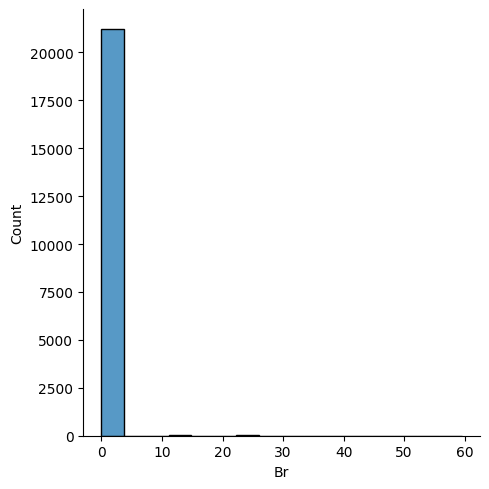

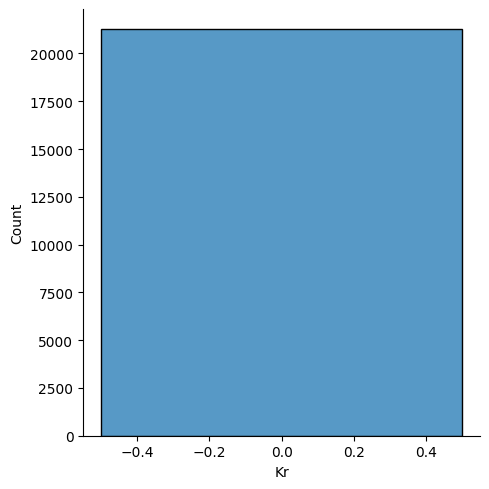

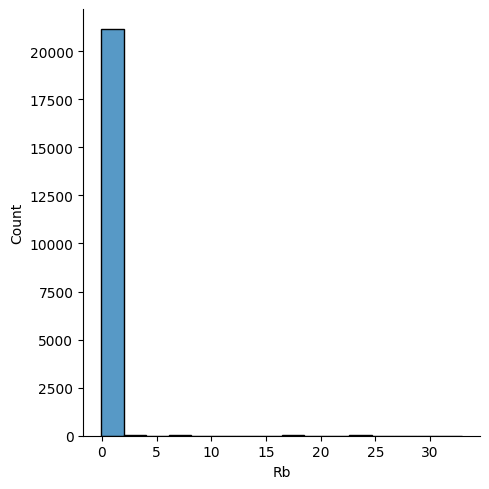

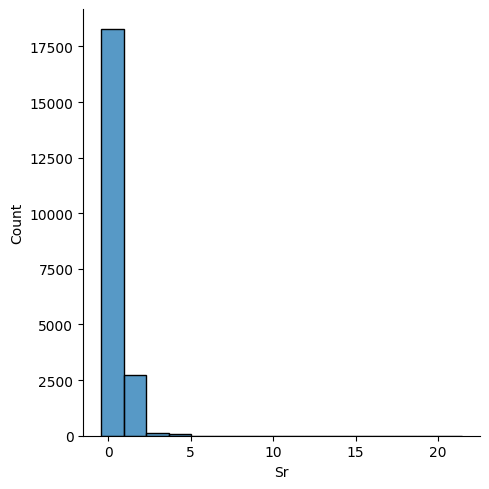

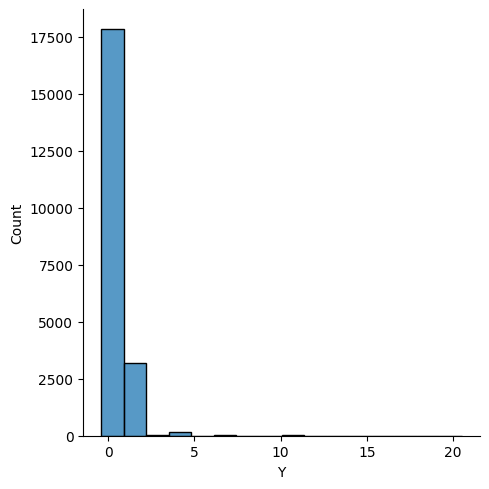

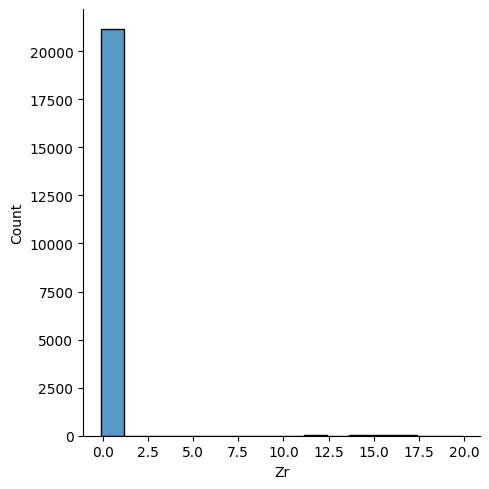

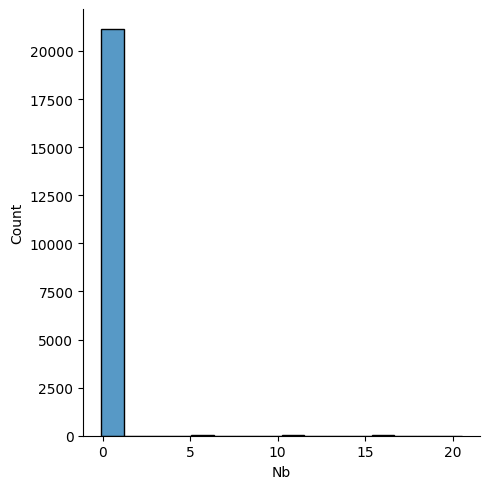

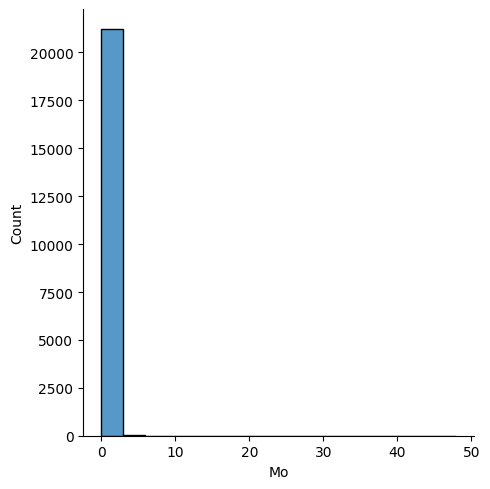

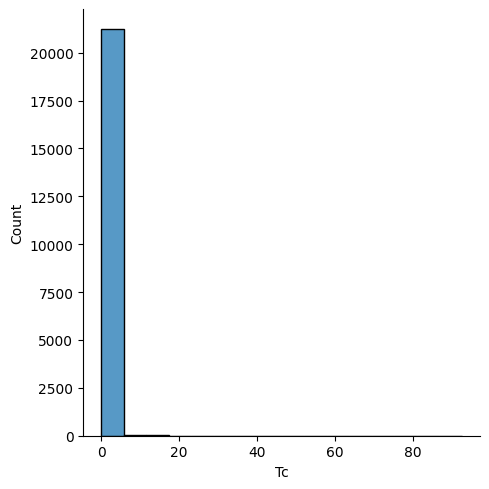

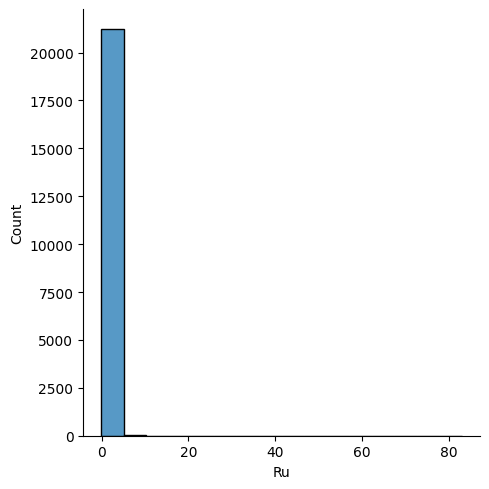

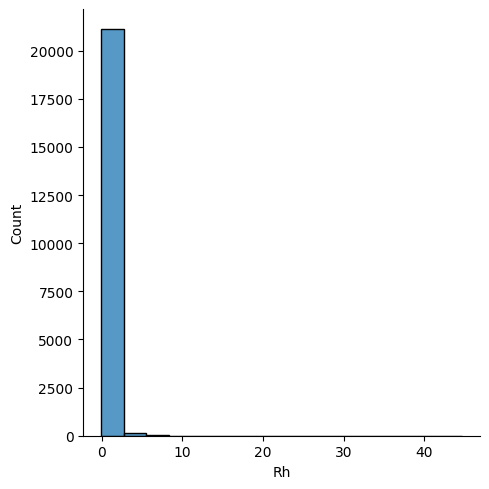

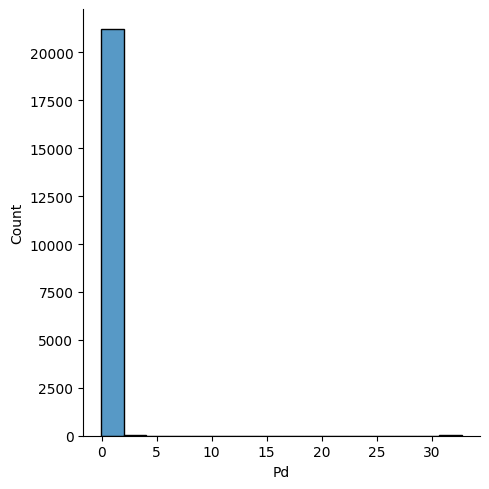

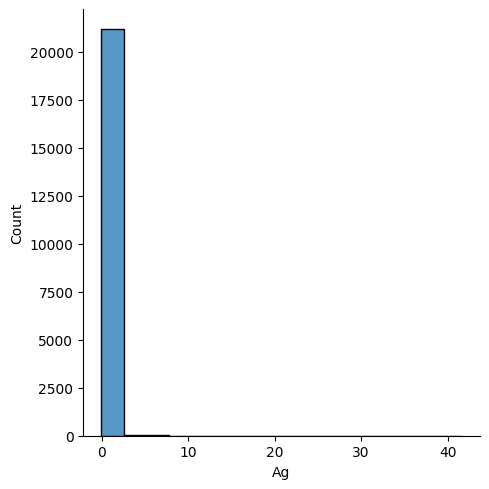

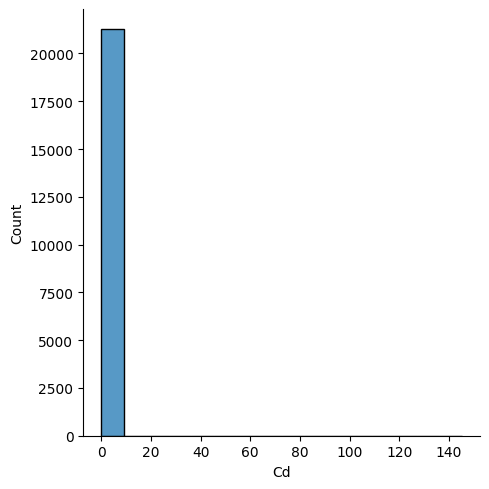

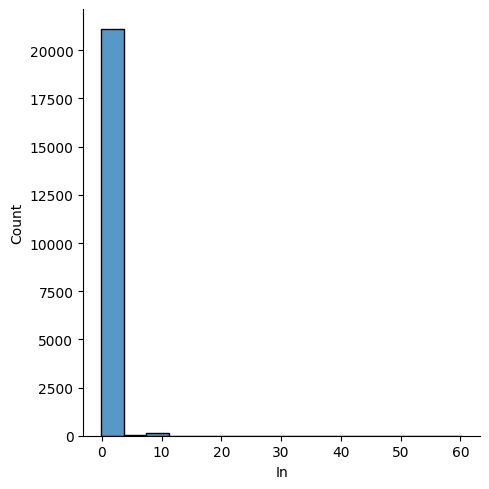

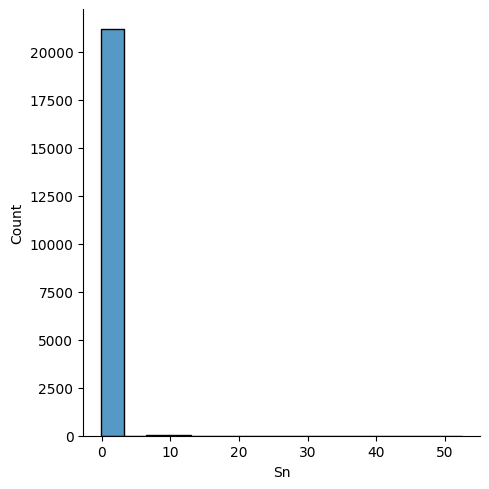

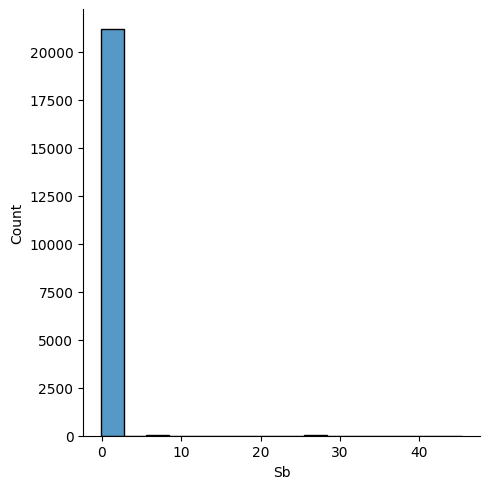

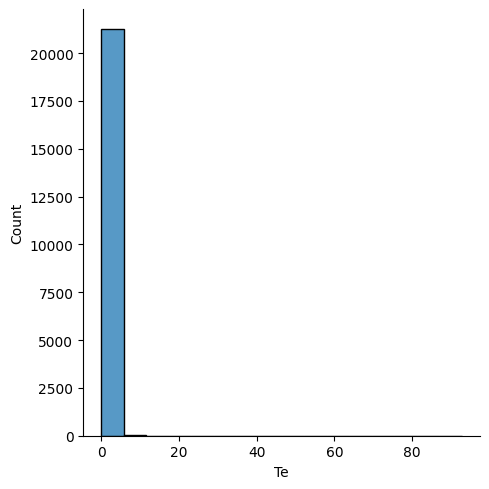

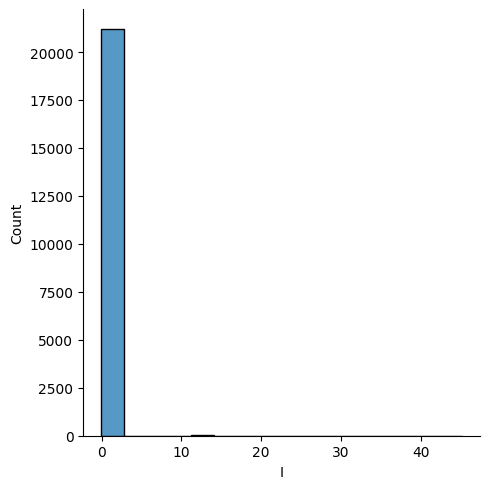

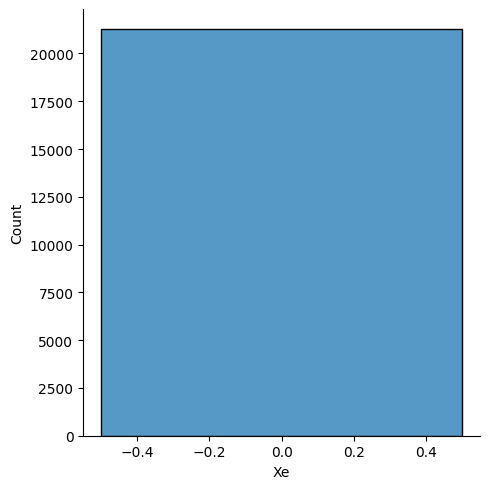

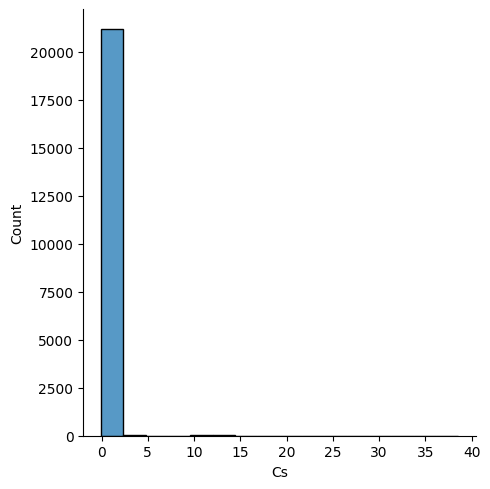

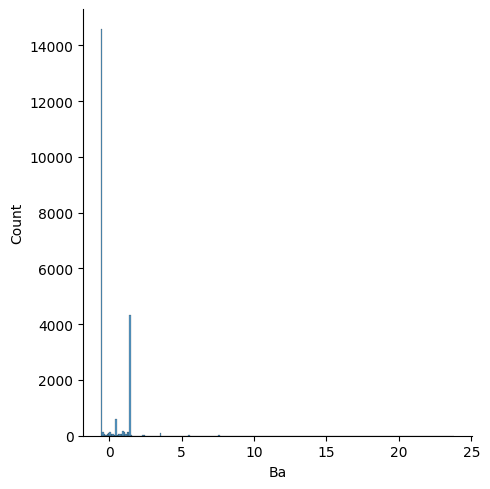

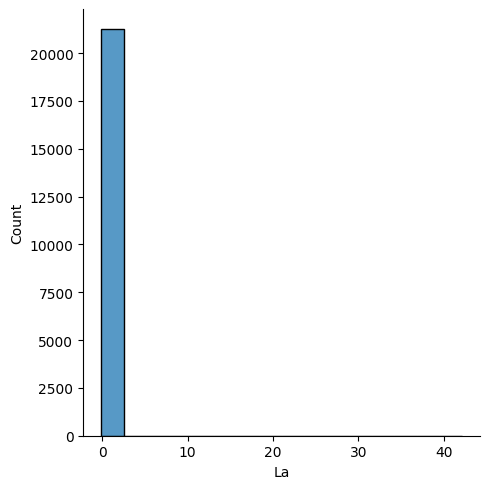

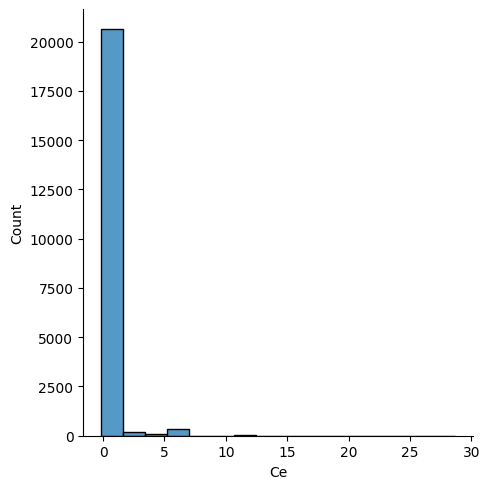

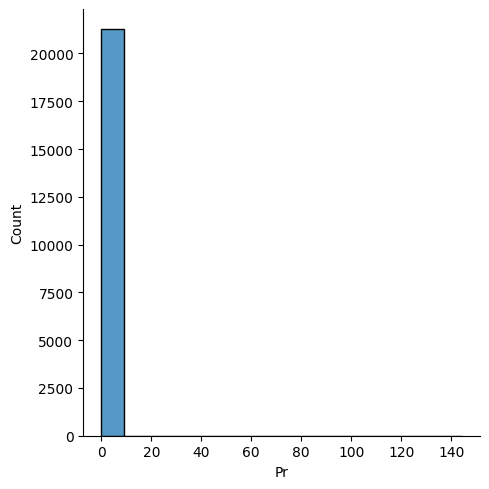

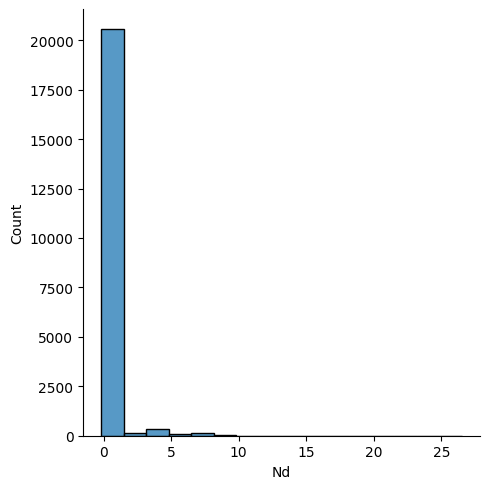

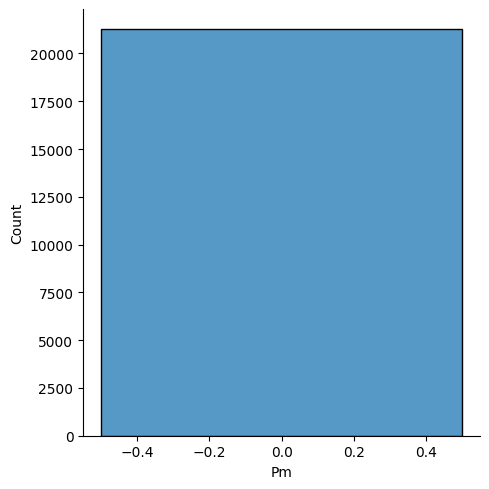

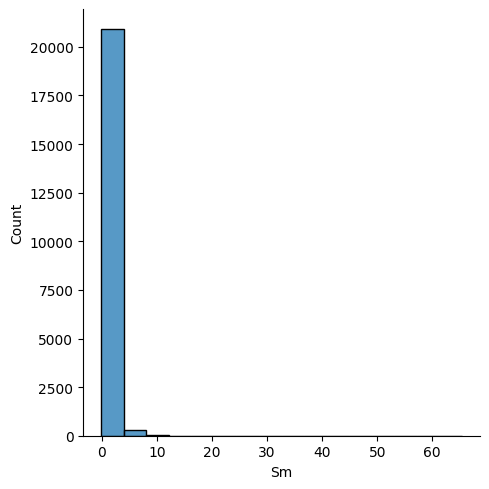

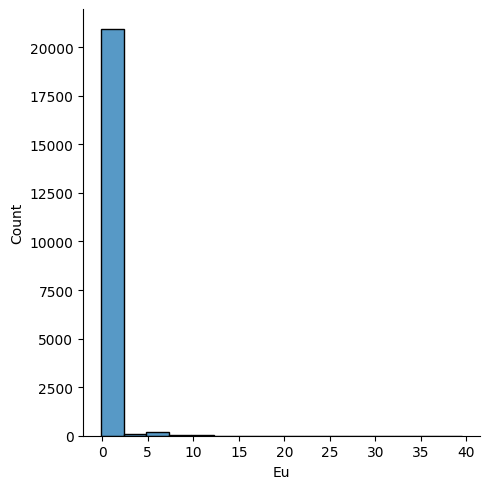

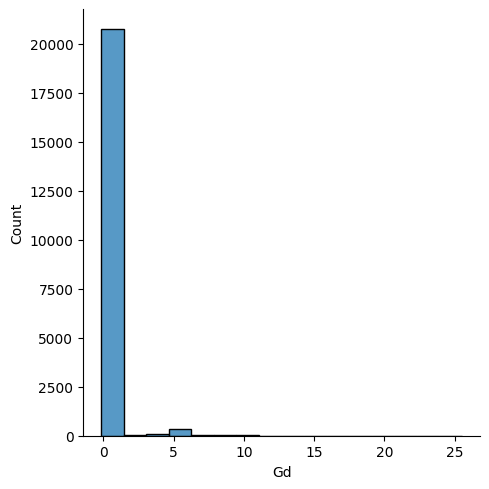

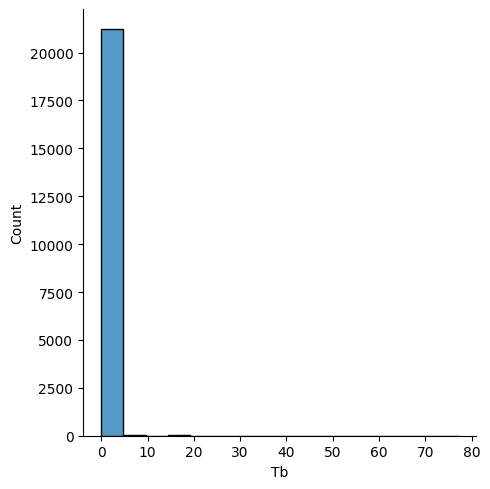

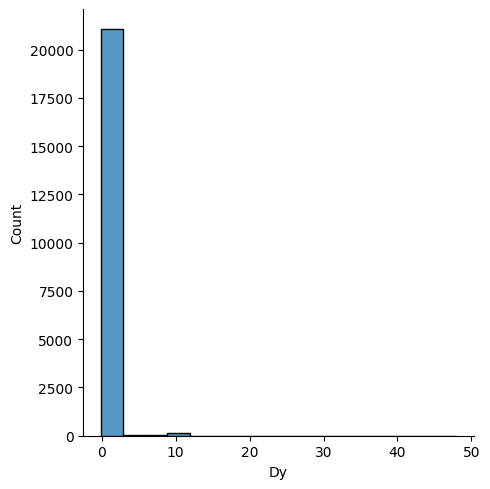

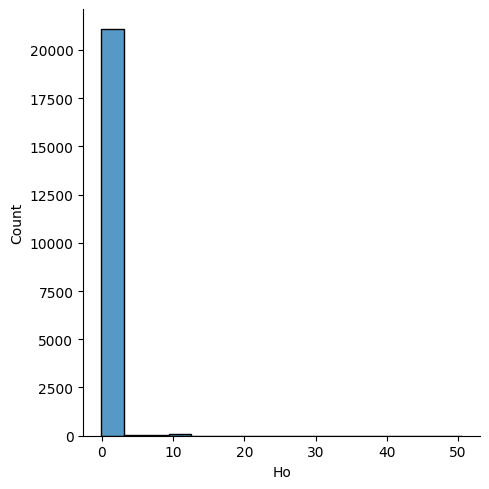

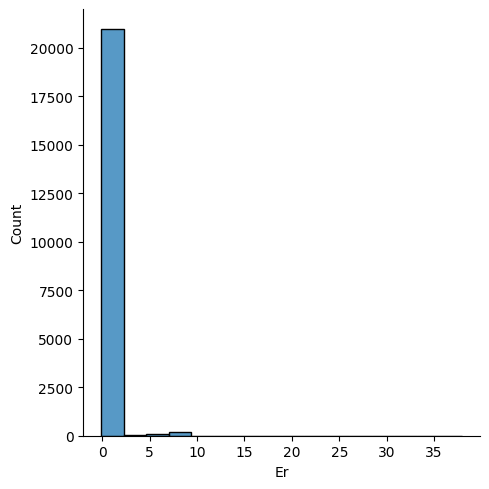

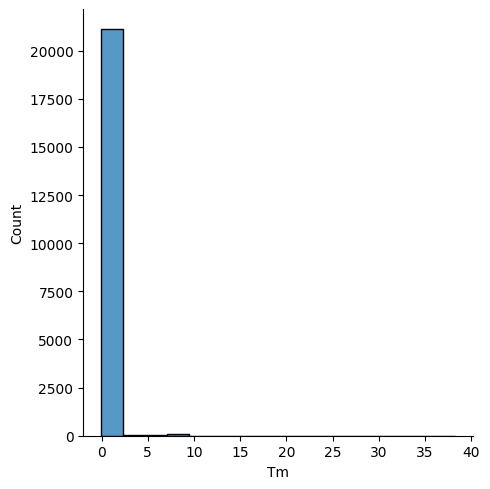

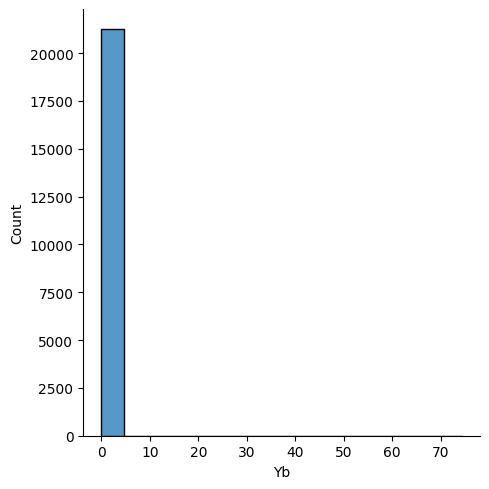

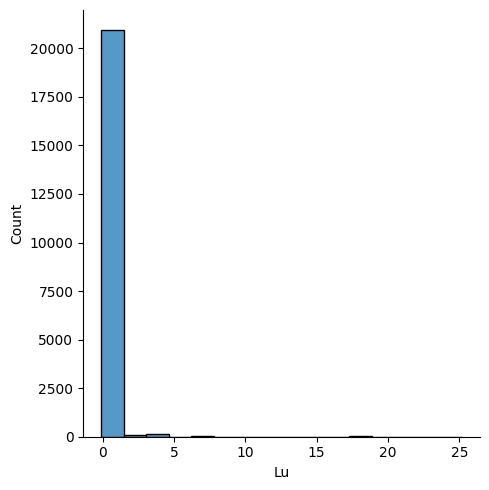

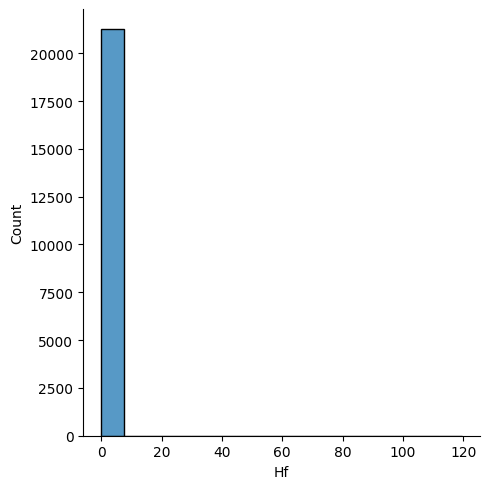

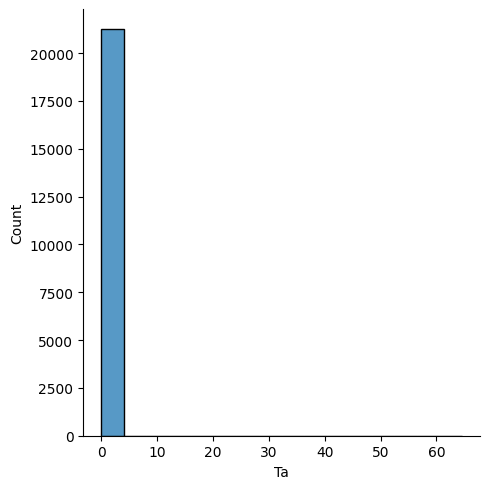

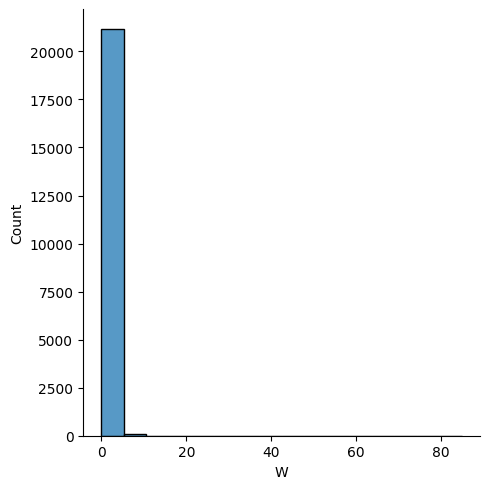

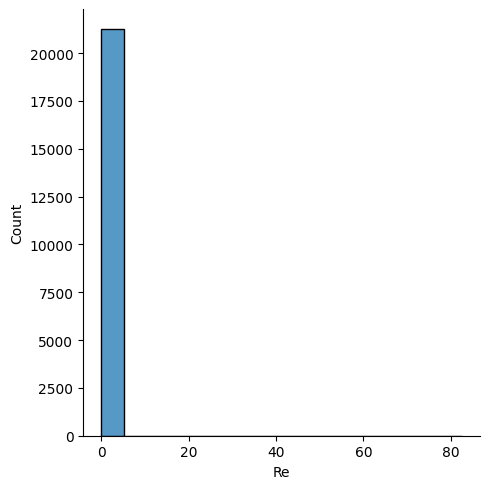

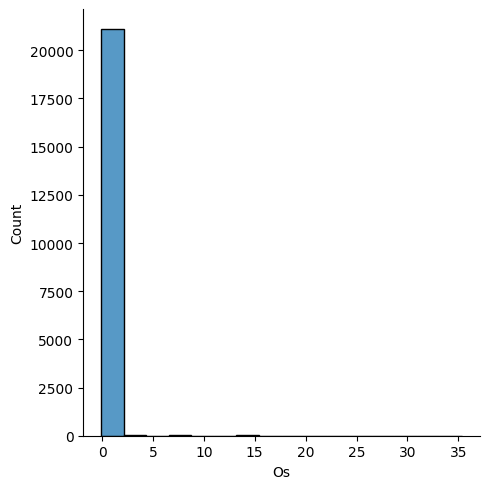

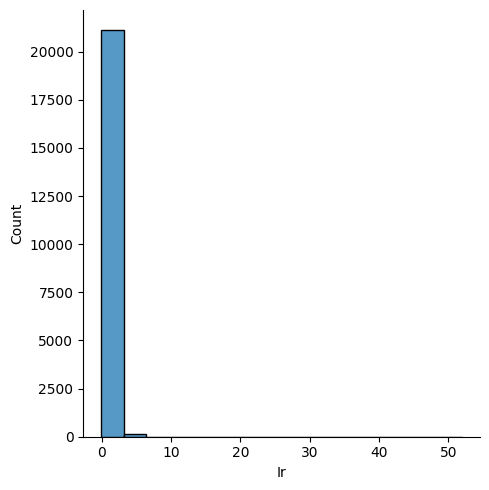

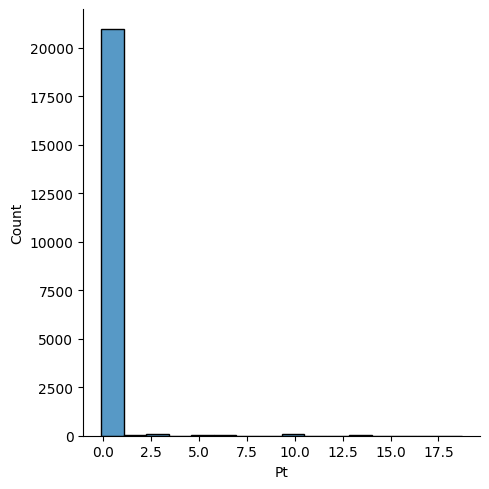

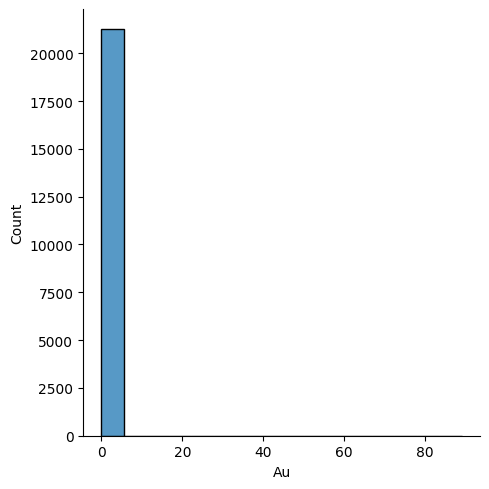

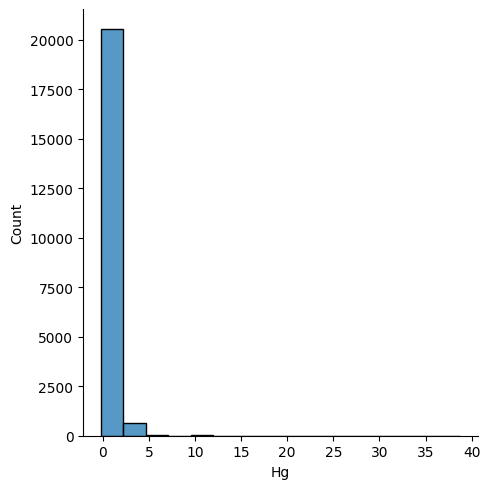

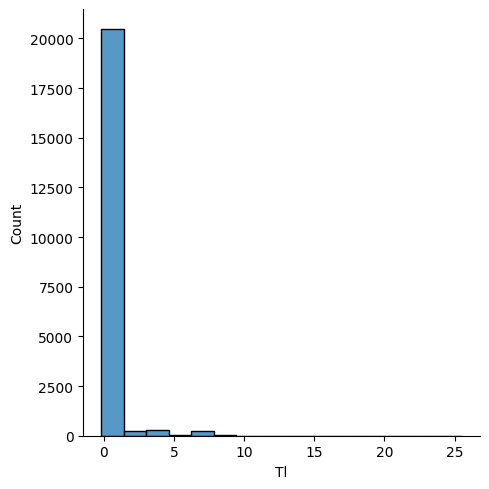

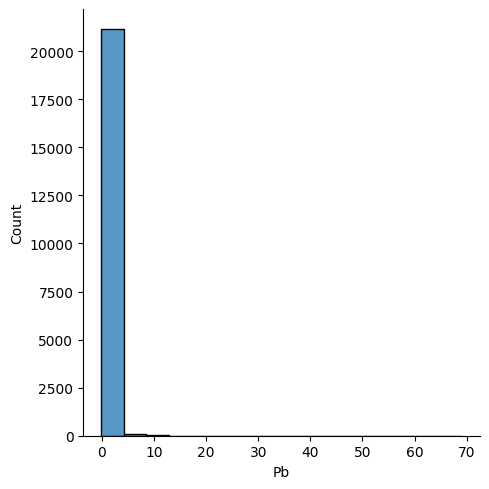

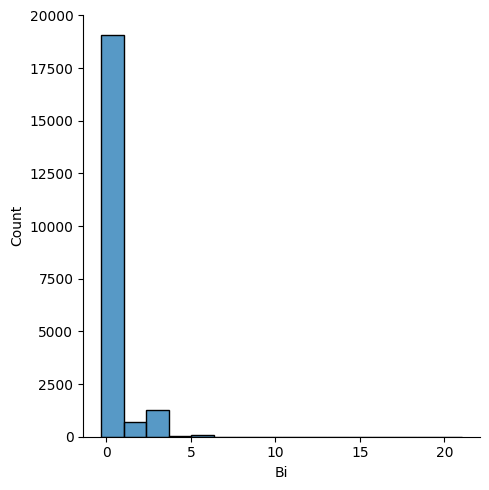

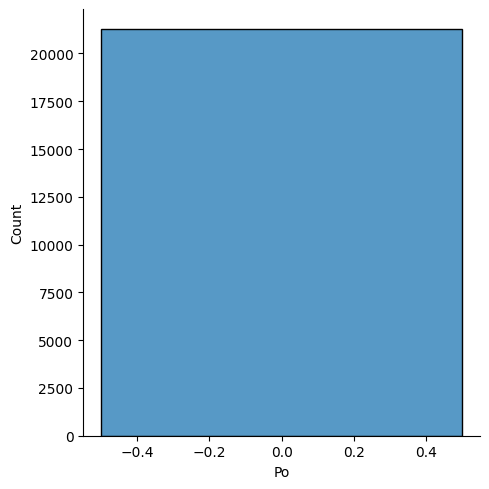

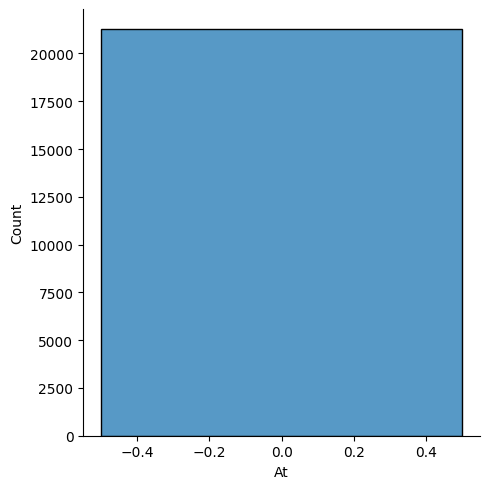

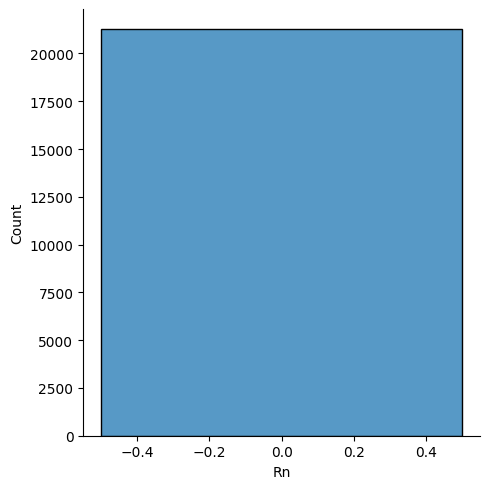

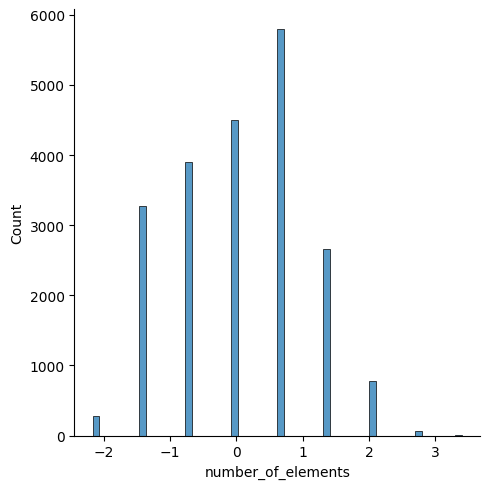

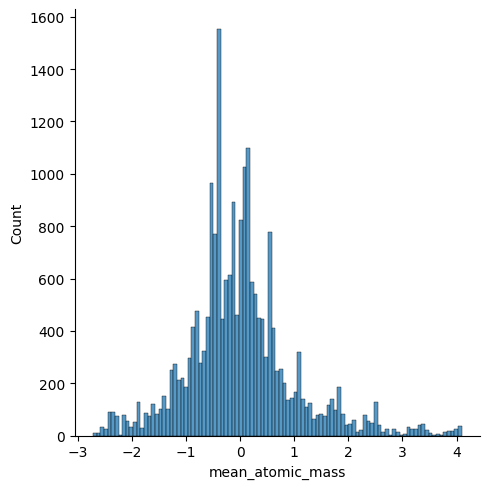

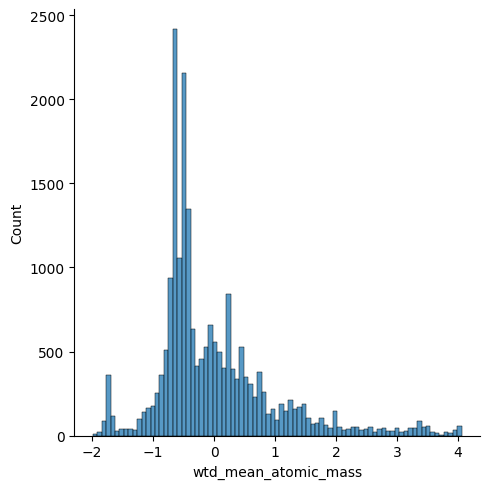

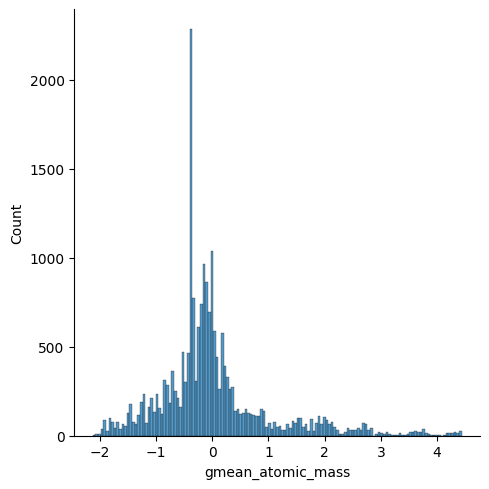

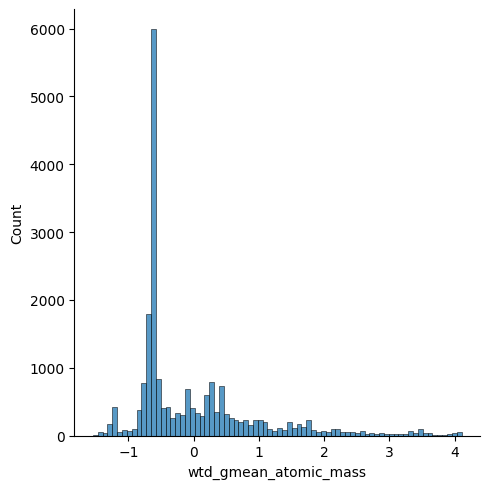

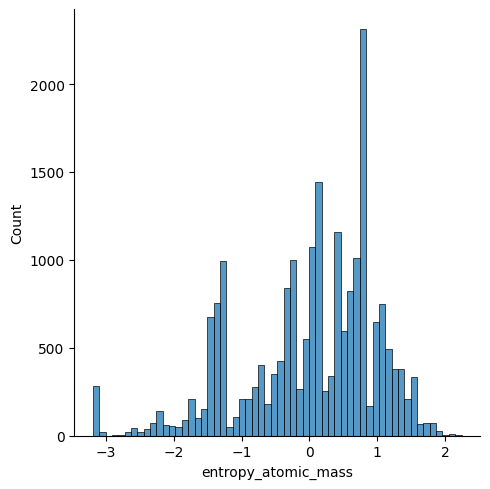

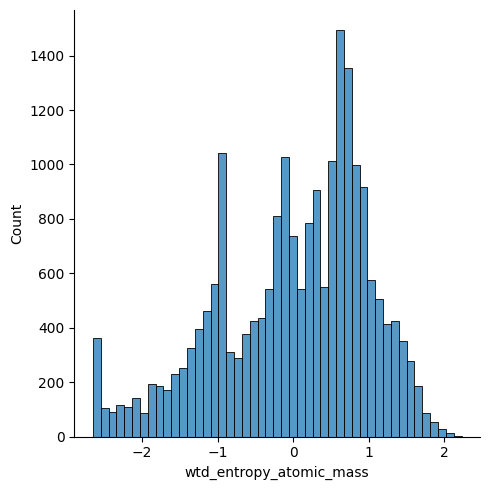

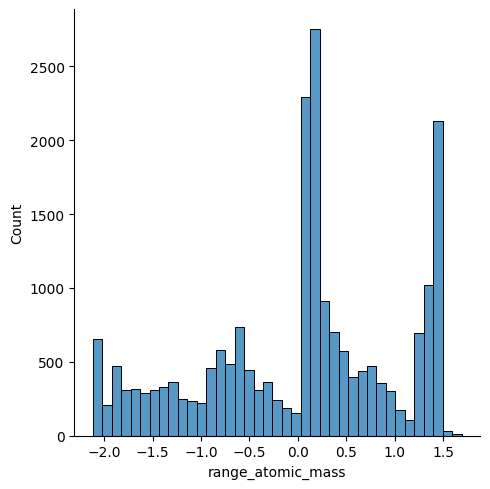

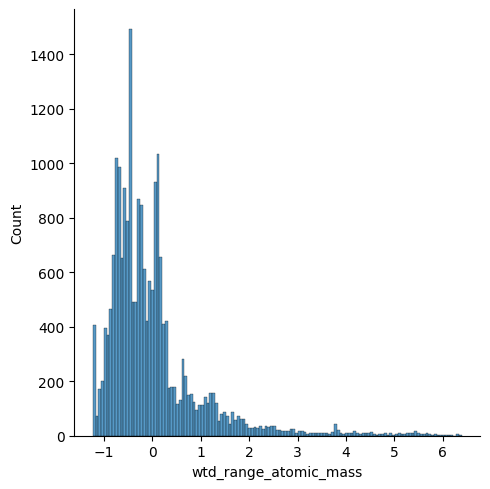

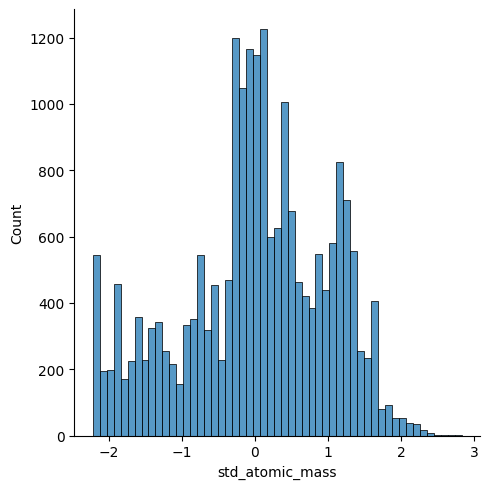

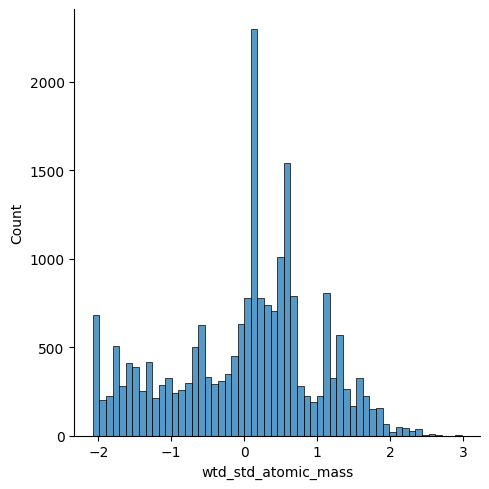

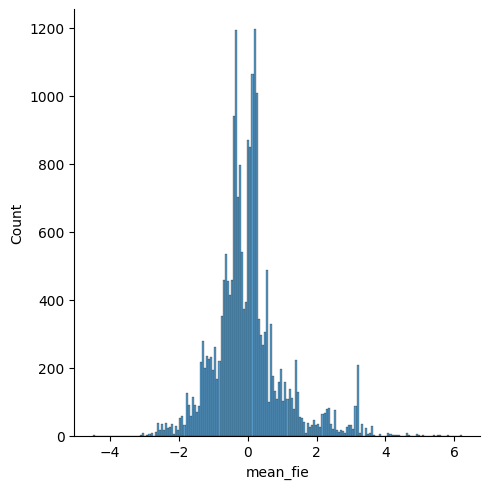

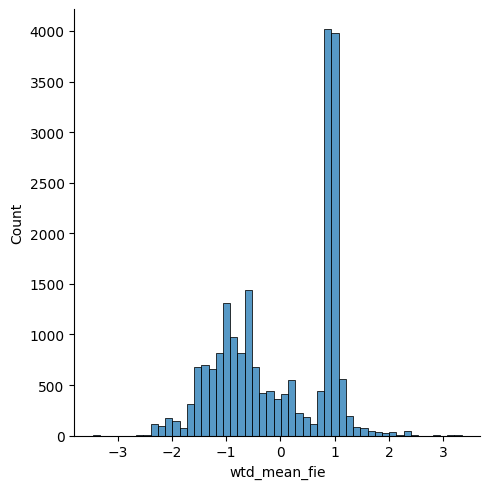

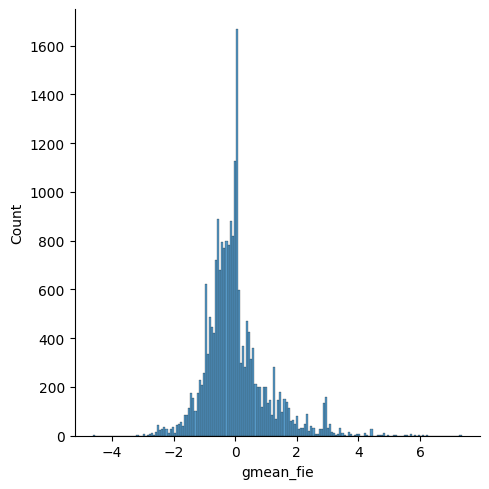

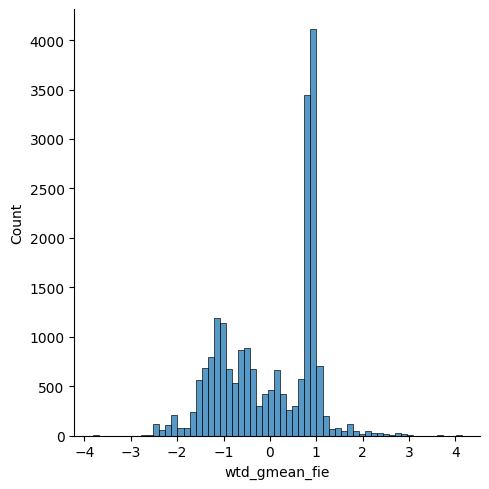

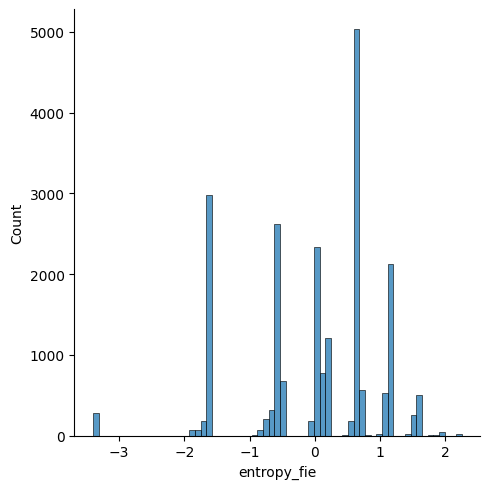

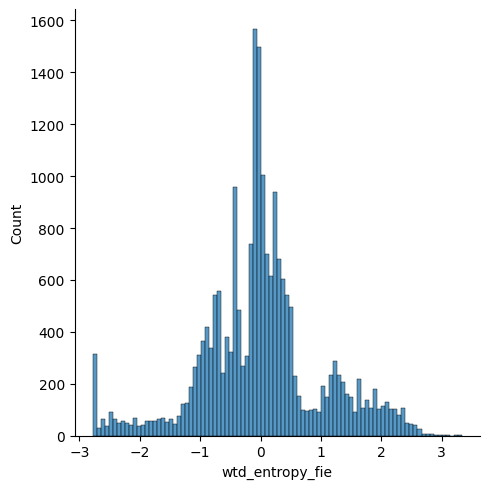

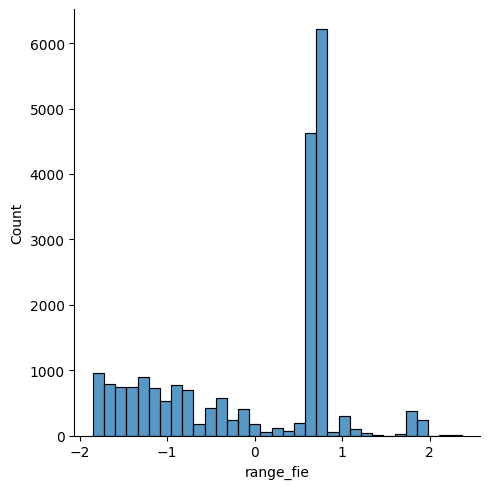

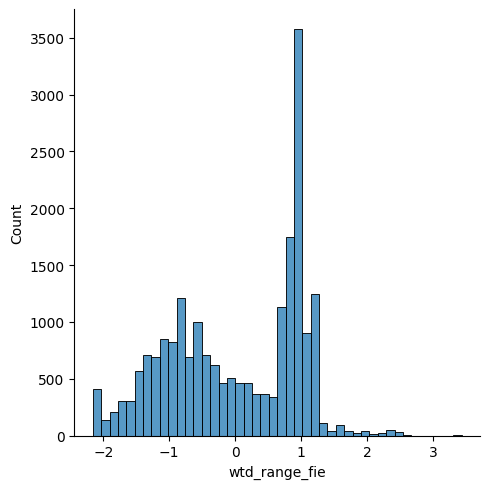

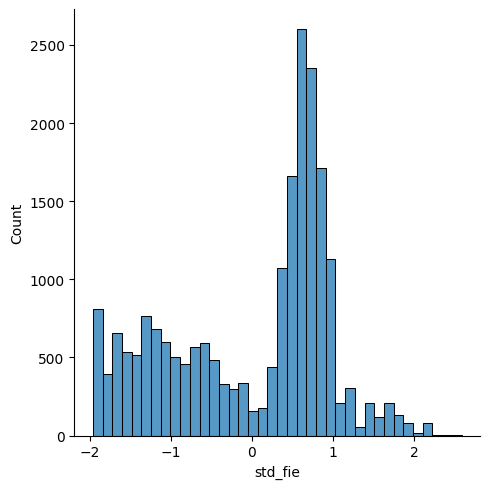

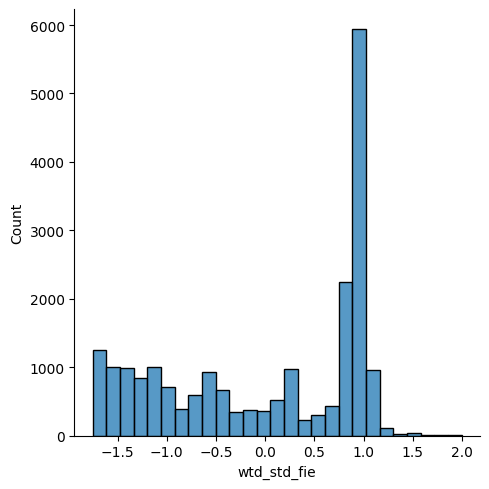

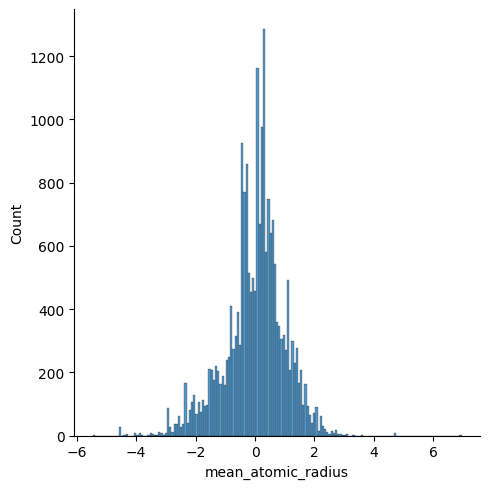

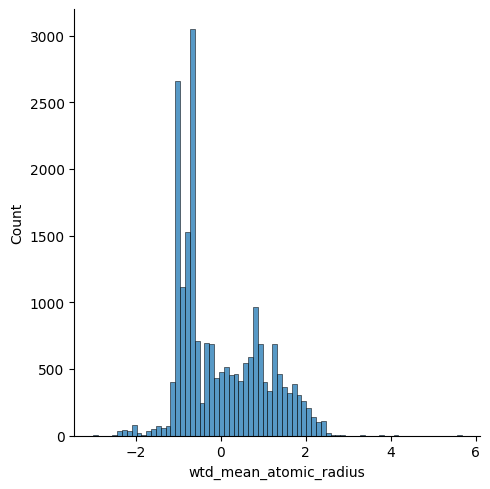

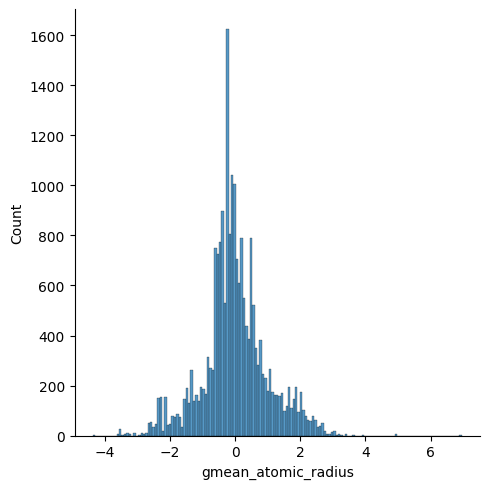

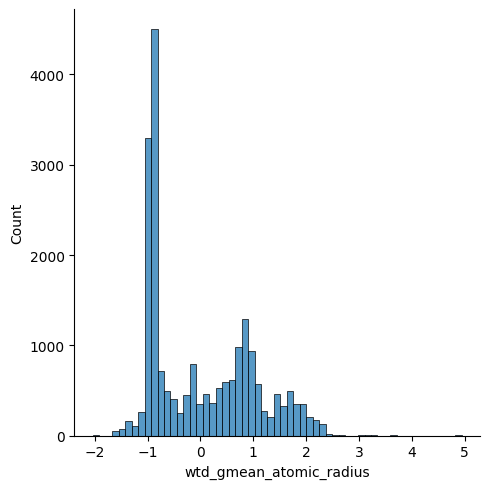

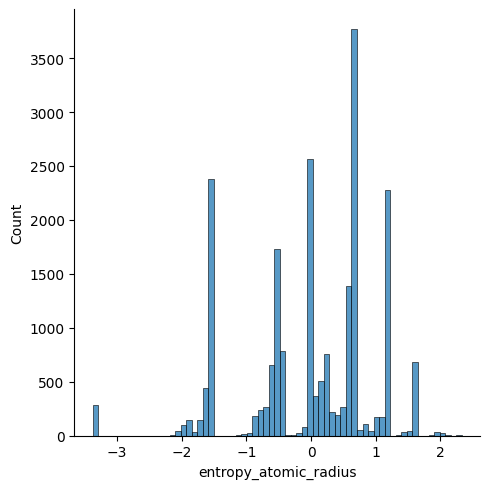

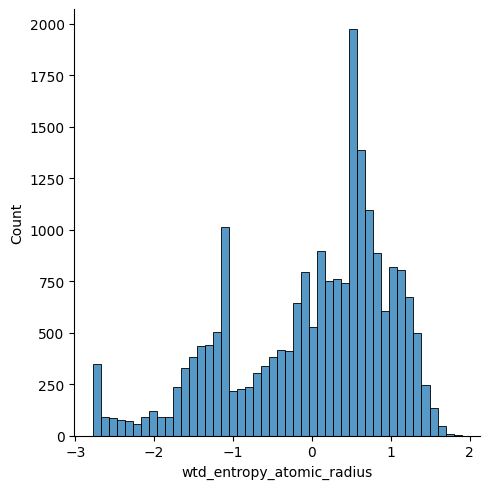

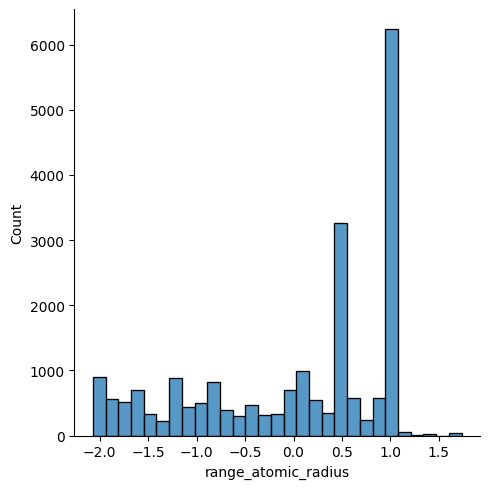

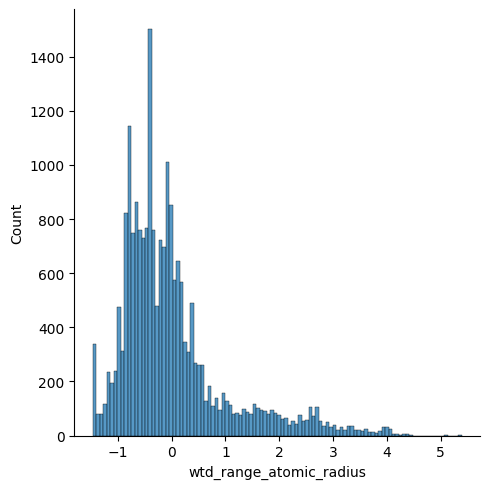

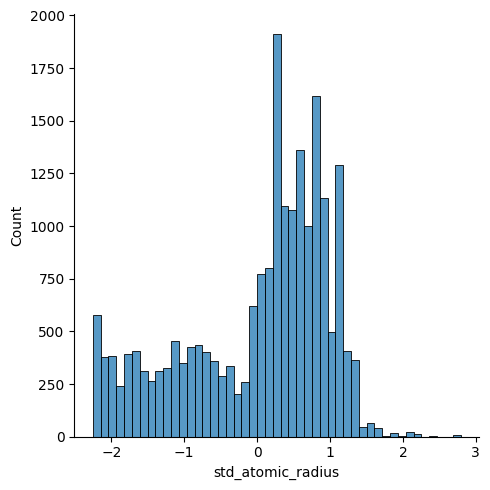

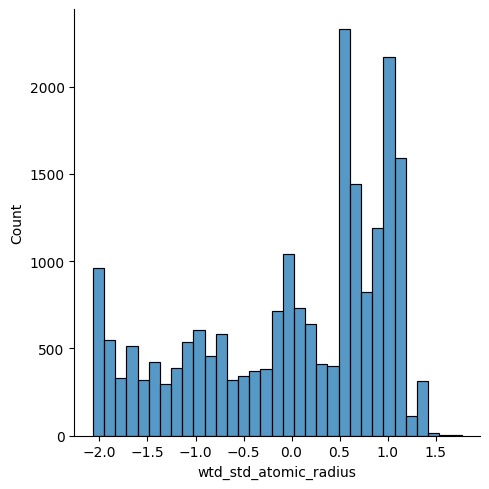

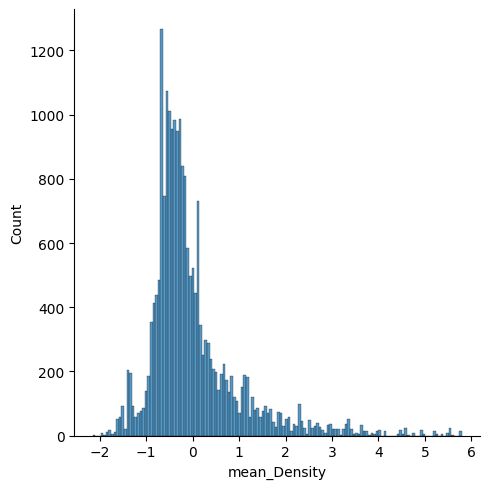

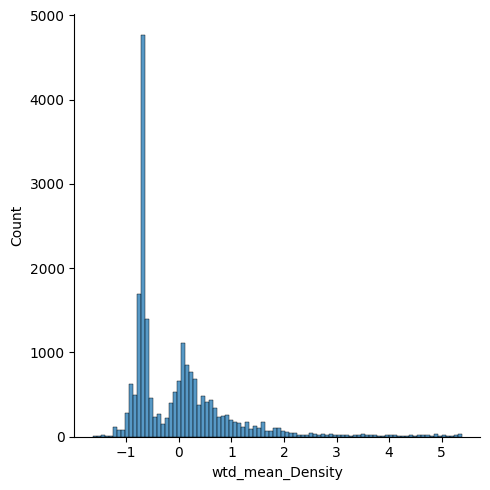

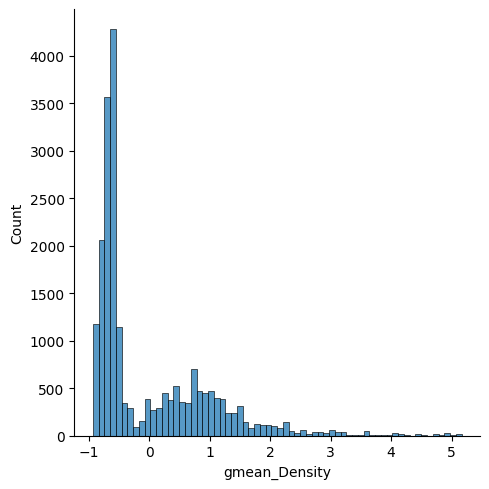

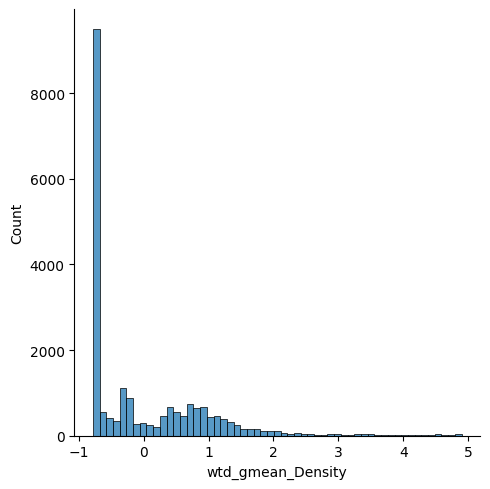

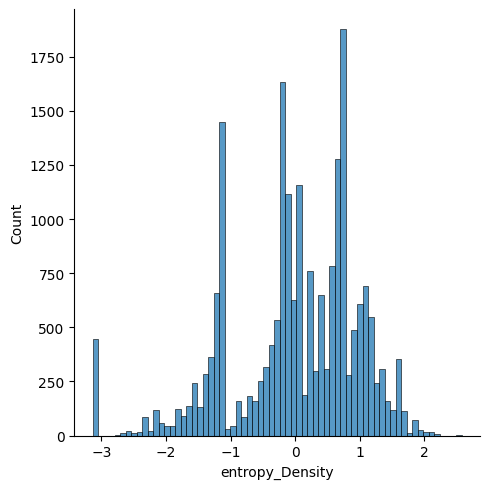

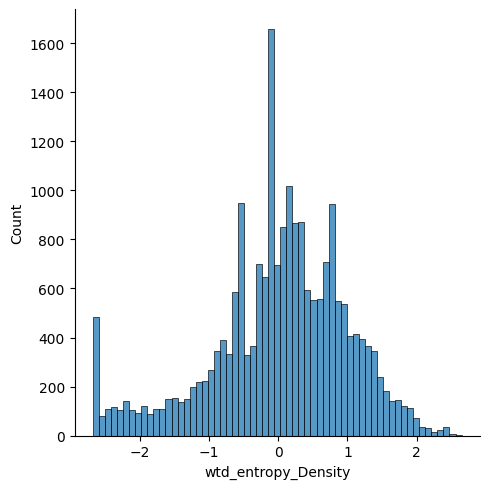

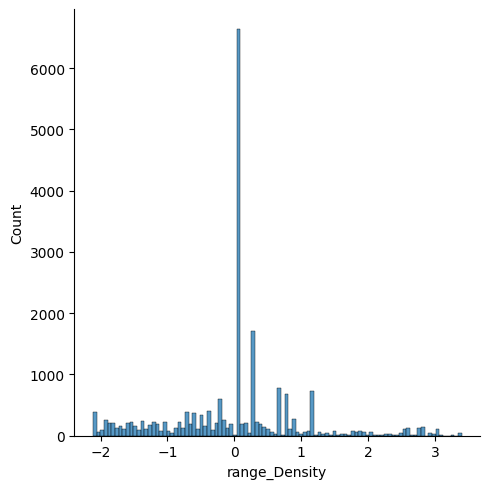

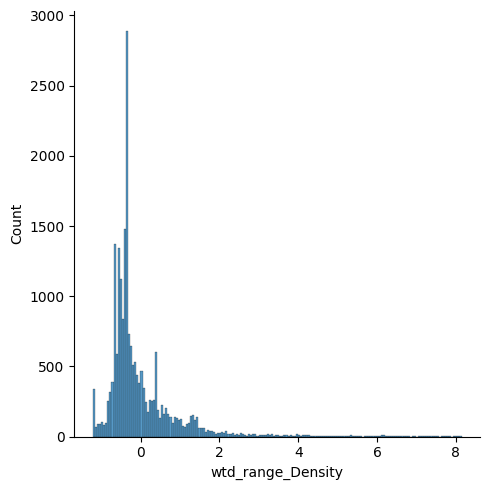

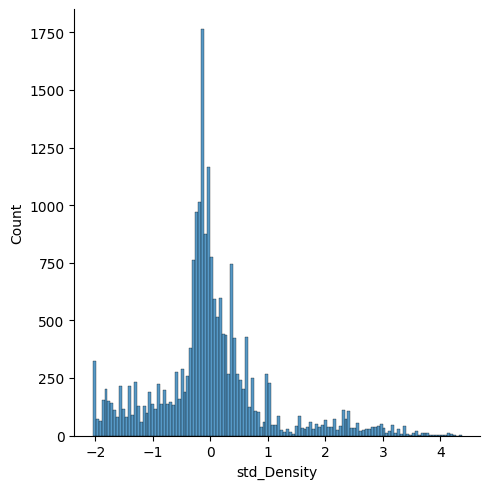

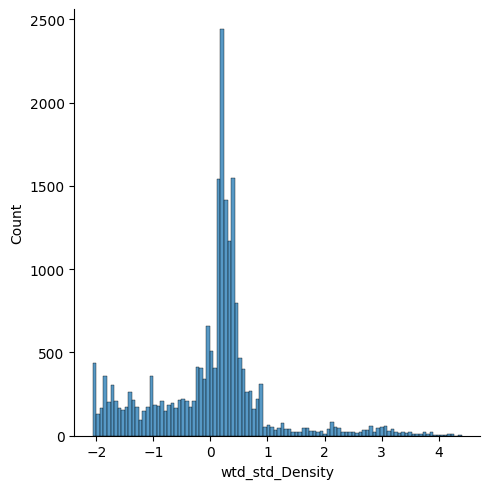

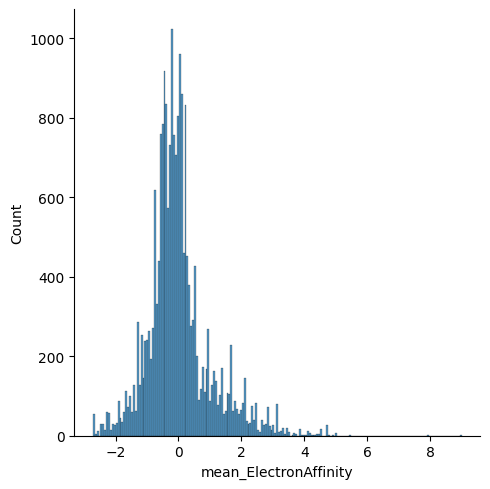

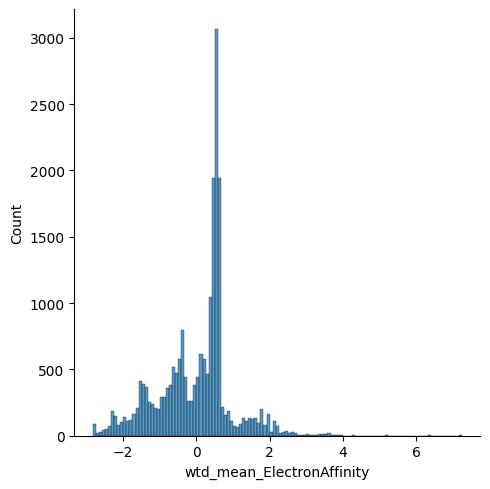

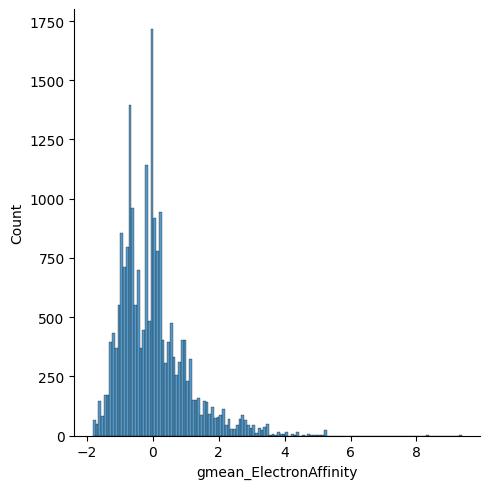

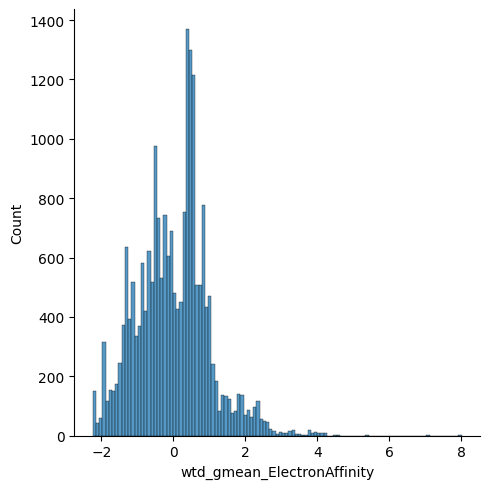

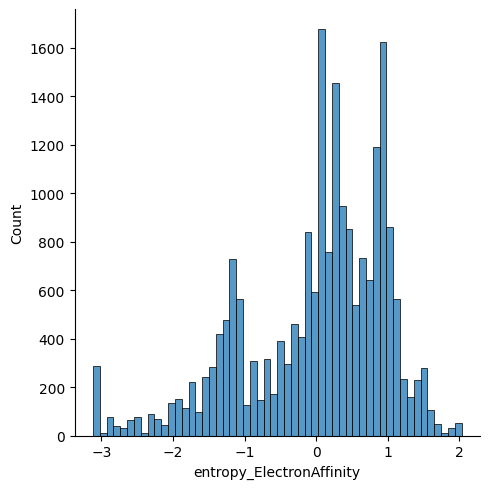

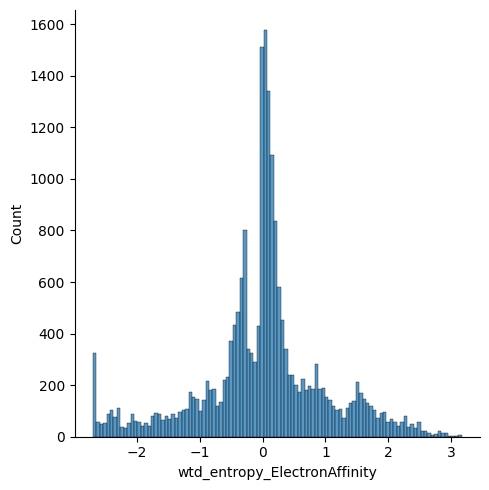

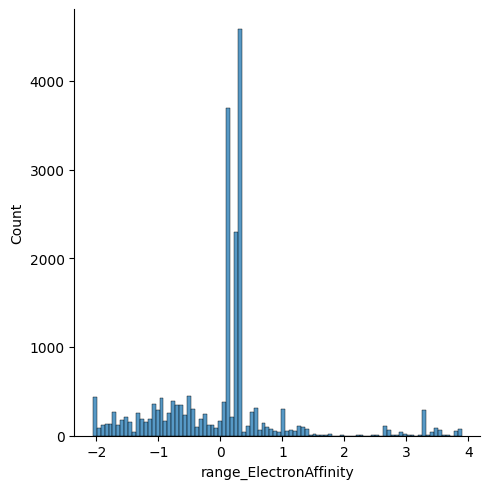

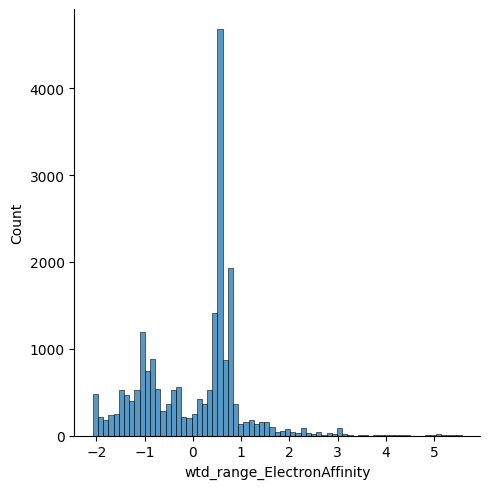

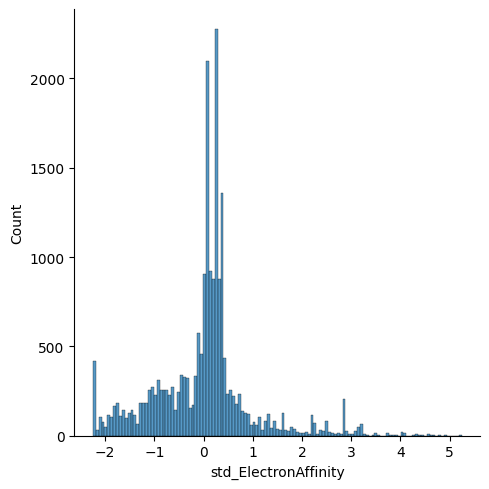

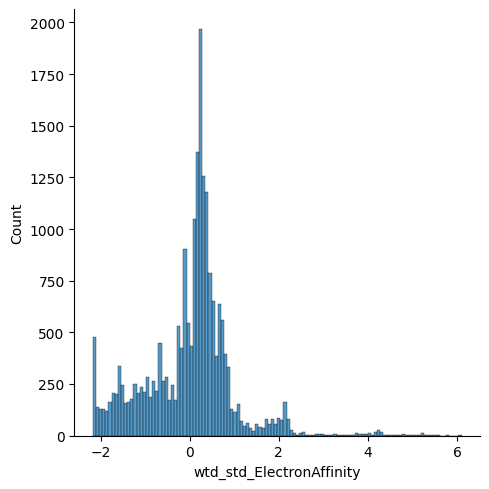

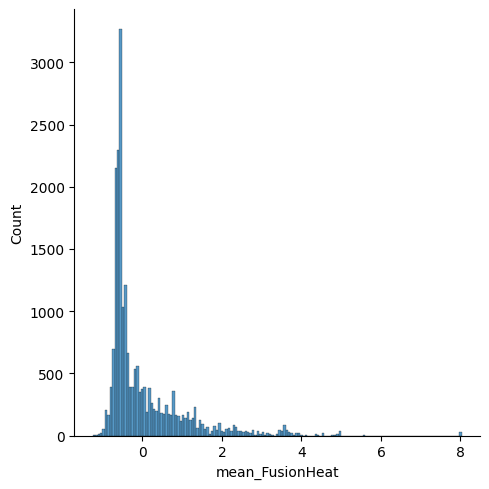

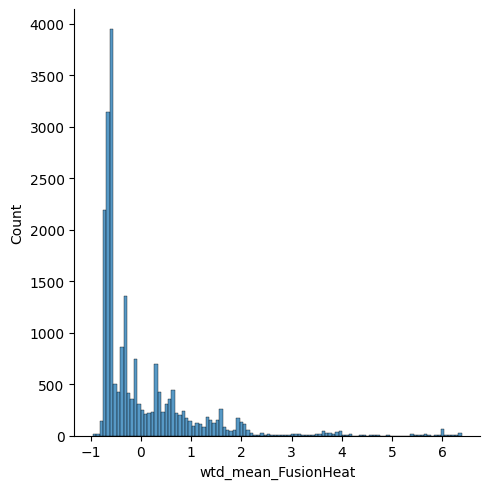

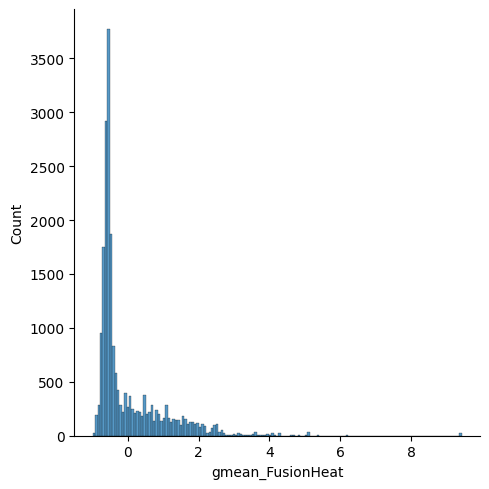

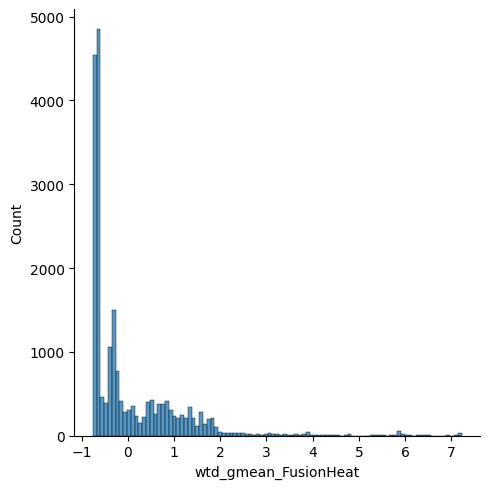

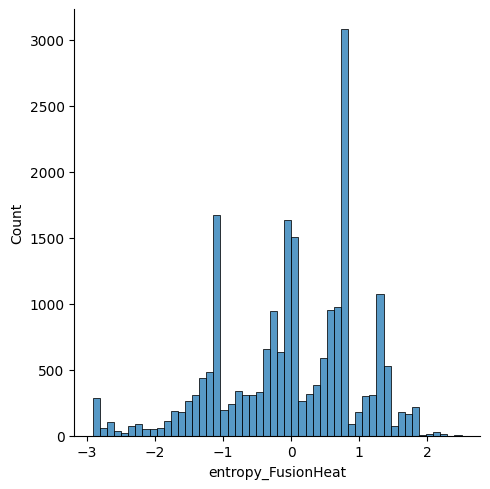

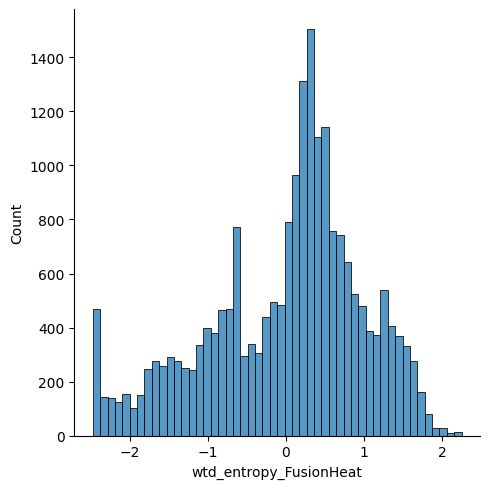

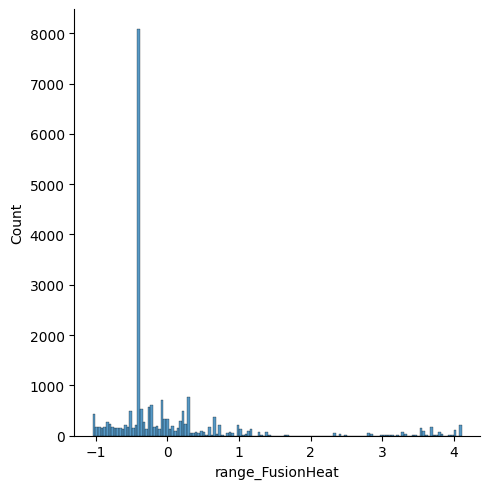

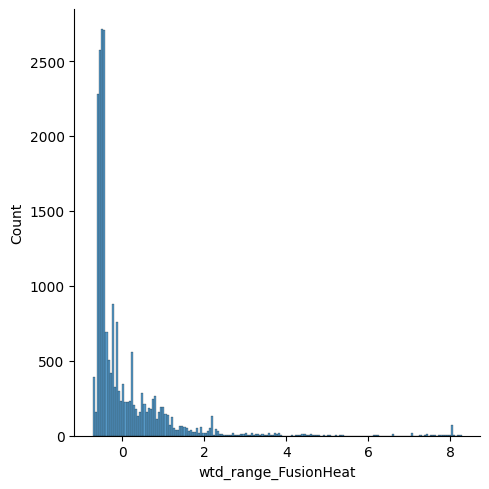

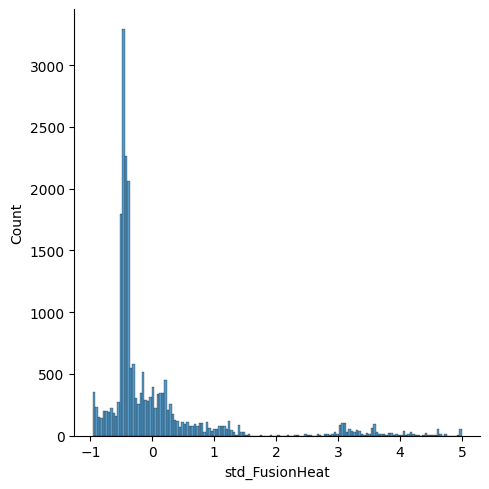

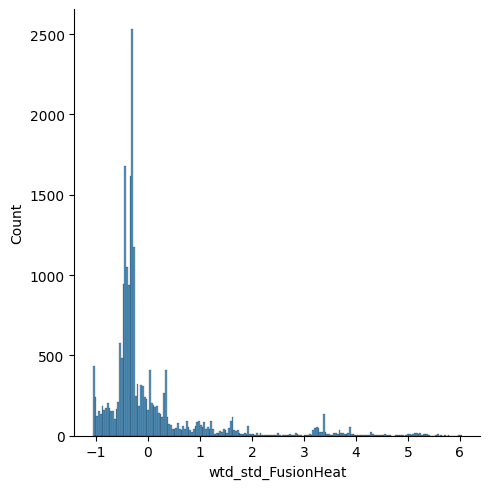

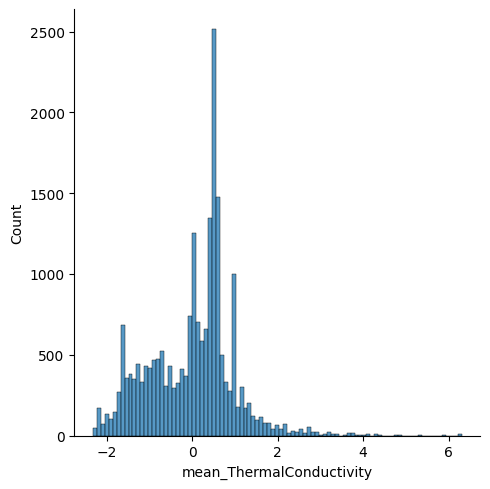

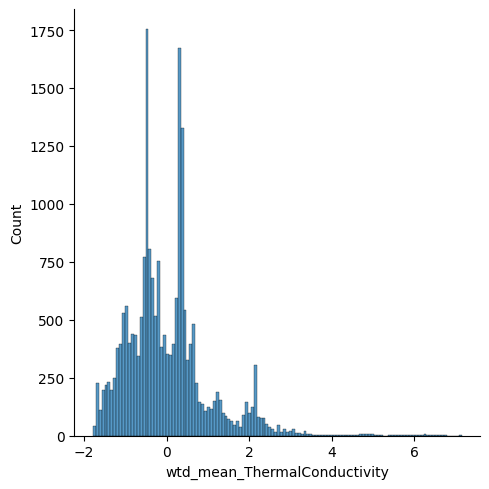

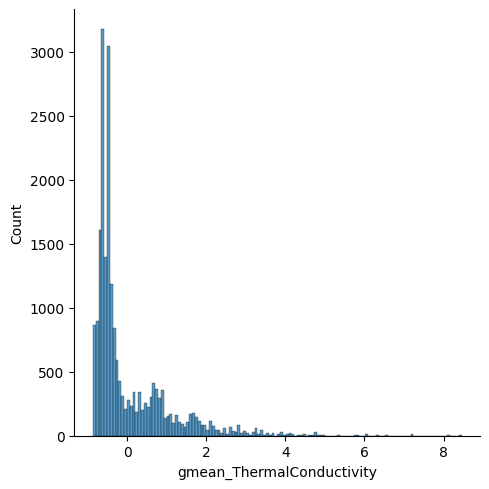

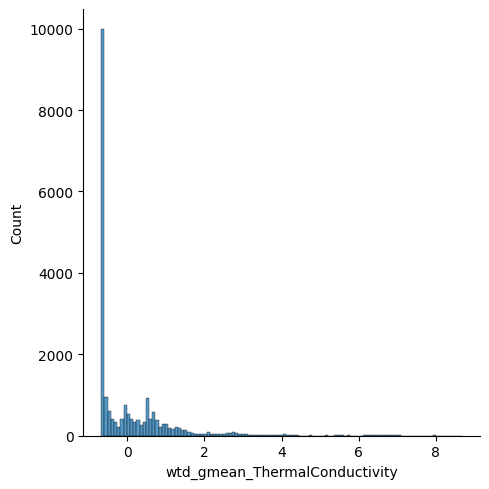

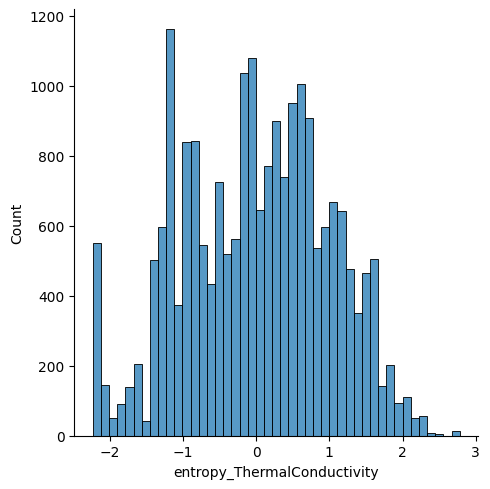

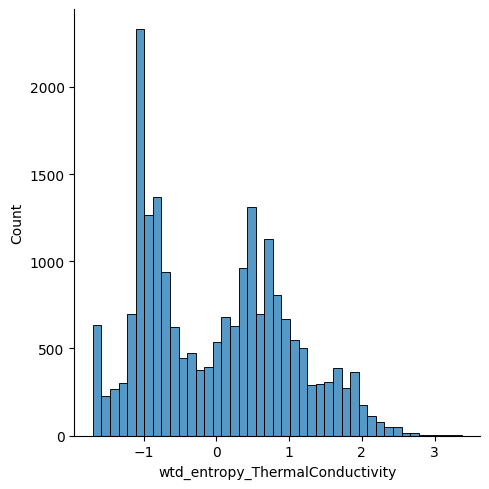

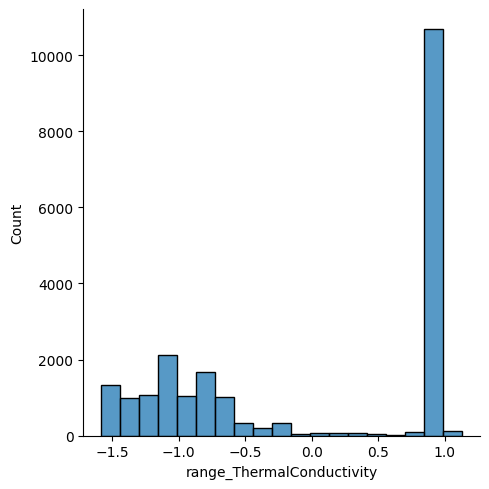

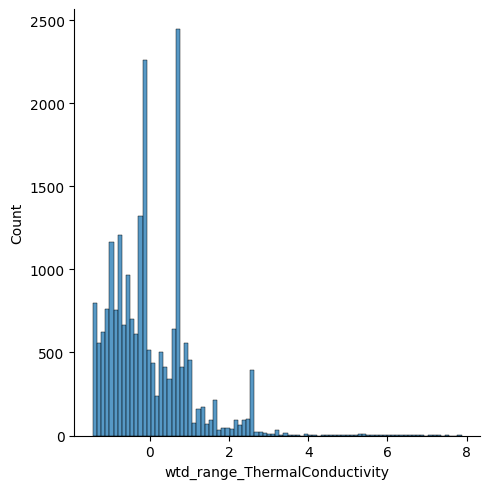

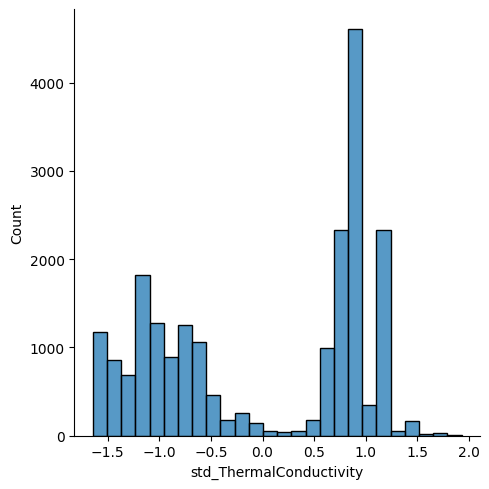

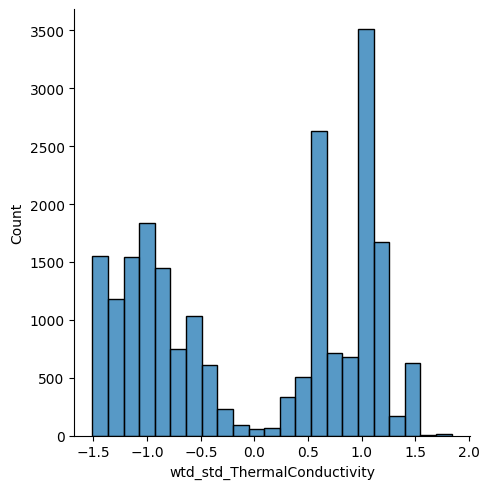

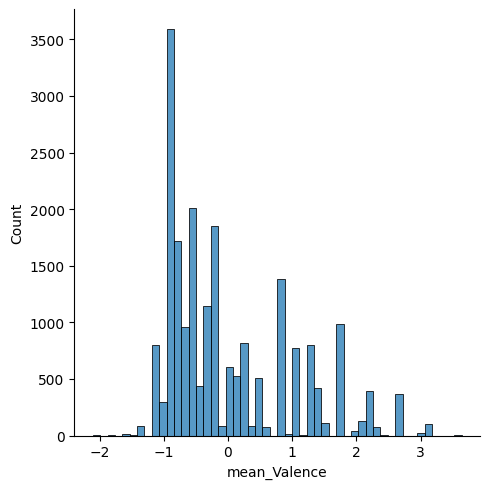

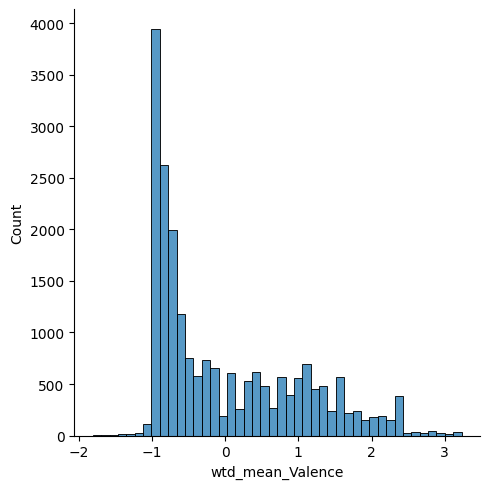

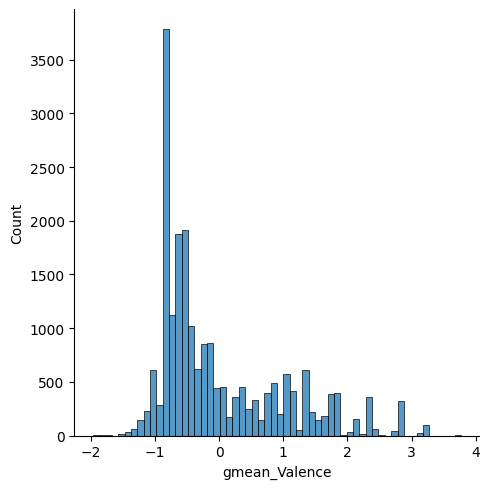

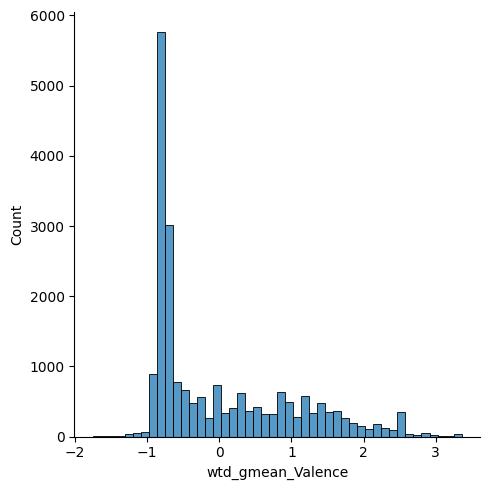

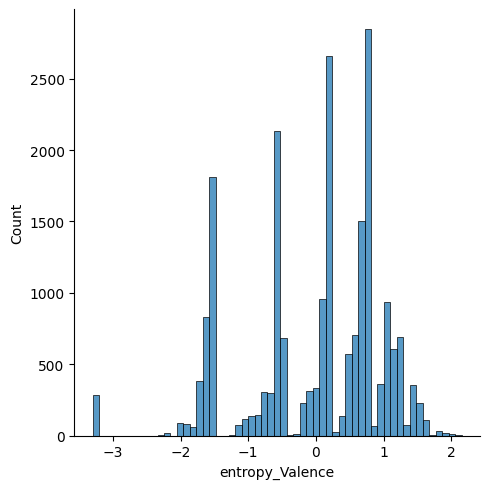

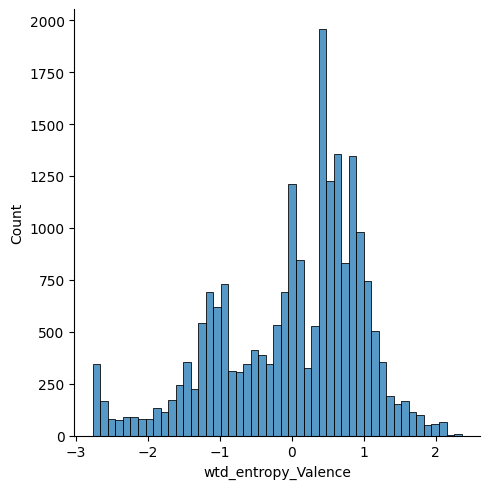

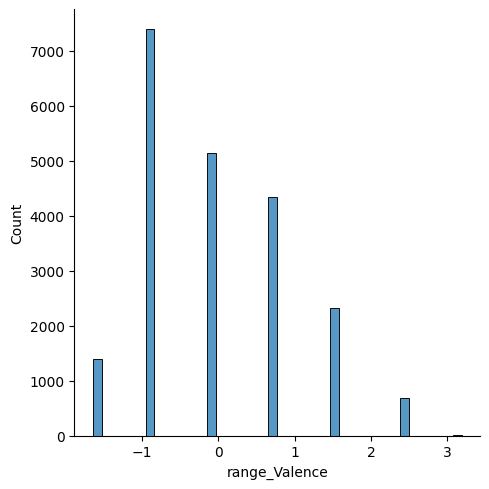

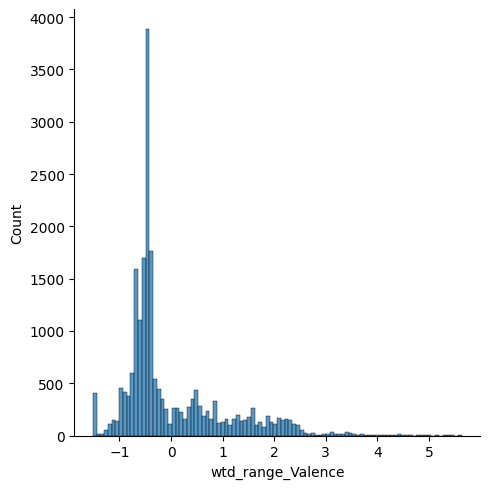

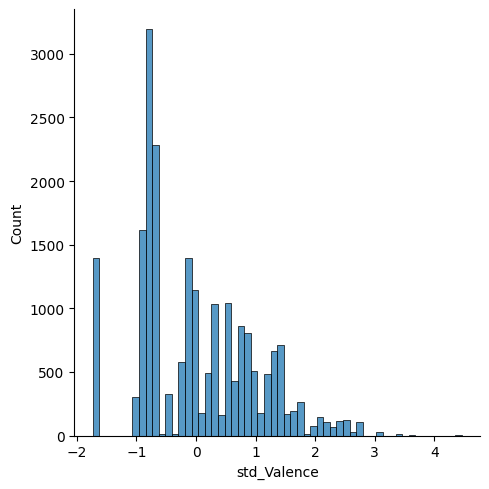

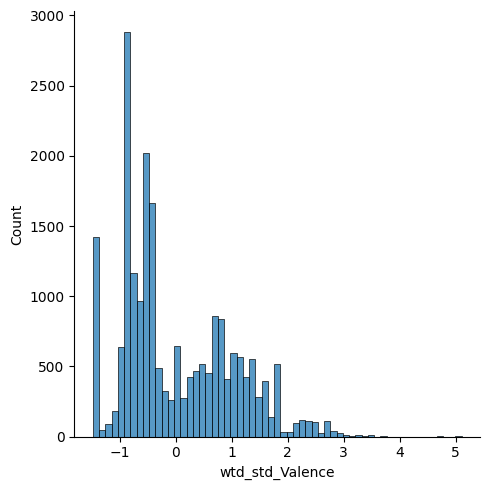

1:1: E265 block comment should start with '# '
1:56: W291 trailing whitespace
3:28: E251 unexpected spaces around keyword / parameter equals
3:30: E251 unexpected spaces around keyword / parameter equals


In [13]:
#Re-examine the plots again to see the data normalized. 
for i in X_scaled.columns:
    sns.displot(X_scaled, x = X_scaled[i])
    plt.show()

#### Evaluate two ways of collinearity with VIF and Corr

In [14]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i)
                   for i in range(len(X_scaled.columns))]

print(vif_data)

C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning:

invalid value encountered in scalar divide



                             feature          VIF
0                                  H     2.003134
1                                 He          NaN
2                                 Li     1.758200
3                                 Be     1.333353
4                                  B     1.586689
5                                  C     5.965127
6                                  N     1.528875
7                                  O    11.309193
8                                  F     2.059536
9                                 Ne          NaN
10                                Na     1.714157
11                                Mg     1.766296
12                                Al     1.195189
13                                Si     2.185812
14                                 P     1.661541
15                                 S     2.350506
16                                Cl     2.466576
17                                Ar          NaN
18                                 K     2.399496


In [15]:
print(vif_data.sort_values('VIF', ascending=False))

                             feature          VIF
98                      wtd_mean_fie  9756.101057
100                    wtd_gmean_fie  6671.835512
158                 wtd_mean_Valence  5772.165883
110          wtd_gmean_atomic_radius  5460.499870
160                wtd_gmean_Valence  4933.605995
101                      entropy_fie  4917.698635
111            entropy_atomic_radius  3818.216032
108           wtd_mean_atomic_radius  3689.892161
157                     mean_Valence  2978.515114
159                    gmean_Valence  2664.047359
97                          mean_fie  2543.099130
99                         gmean_fie  1996.542447
161                  entropy_Valence  1917.147961
109              gmean_atomic_radius  1268.412973
107               mean_atomic_radius  1037.603175
90             wtd_gmean_atomic_mass   952.464526
88              wtd_mean_atomic_mass   894.969523
138              wtd_mean_FusionHeat   649.808659
106                      wtd_std_fie   541.976871


In [16]:
# Remove variables that are correlated
# columns that start with wtd and gmean
# columns that contain fie, radius, ThermalConducitivity and Density

X_scaled_clean = \
    X_scaled.loc[:, ~X_scaled.columns.str.startswith('wtd')]
X_scaled_clean = \
    X_scaled_clean.loc[:, ~X_scaled_clean.columns.str.startswith('gmean')]
X_scaled_clean = \
    X_scaled_clean.loc[:, ~X_scaled_clean.columns.str.contains('fie')]
X_scaled_clean = \
    X_scaled_clean.loc[:, ~X_scaled_clean.columns.str.contains('radius')]
X_scaled_clean = \
    X_scaled_clean.loc[:,
                       ~X_scaled_clean
                       .columns.str.contains('ThermalConductivity')]
X_scaled_clean = \
    X_scaled_clean.loc[:, ~X_scaled_clean.columns.str.contains('Density')]

In [17]:
# Examine the correlation matrix of the variables
corr = X_scaled_clean.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\shijo\AppData\Local\Temp\ipykernel_30164\1888125624.py:4: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`

C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\pandas\io\formats\style.py:3925: RuntimeWarning:

All-NaN slice encountered

C:\ProgramData\Anaconda3\envs\QTW\lib\site-packages\pandas\io\formats\style.py:3926: RuntimeWarning:

All-NaN slice encountered



In [18]:

# remove columns based on high correlation
if 'number_of_elements' in X_scaled_clean:
    del X_scaled_clean['number_of_elements']
if 'std_FusionHeat' in X_scaled_clean:
    del X_scaled_clean['std_FusionHeat']
if 'entropy_ElectronAffinity' in X_scaled_clean:
    del X_scaled_clean['entropy_ElectronAffinity']
if 'entropy_FusionHeat' in X_scaled_clean:
    del X_scaled_clean['entropy_FusionHeat']
if 'entropy_Valence' in X_scaled_clean:
    del X_scaled_clean['entropy_Valence']
if 'std_ElectronAffinity' in X_scaled_clean:
    del X_scaled_clean['std_ElectronAffinity']
if 'std_atomic_mass' in X_scaled_clean:
    del X_scaled_clean['std_atomic_mass']
if 'std_Valence' in X_scaled_clean:
    del X_scaled_clean['std_Valence']
if 'range_FusionHeat' in X_scaled_clean:
    del X_scaled_clean['range_FusionHeat']

In [19]:
# Reevaluate correlation values with the remaining columns
corr_clean = X_scaled_clean.corr()
corr_clean.style.background_gradient()
corr_clean.style.background_gradient().set_precision(2)

C:\Users\shijo\AppData\Local\Temp\ipykernel_30164\1825085981.py:4: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



In [20]:
# Review data frame after the removing correlated variables
X_scaled_clean.columns

Index(['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
       'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb',
       'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In',
       'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
       'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',
       'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At',
       'Rn', 'mean_atomic_mass', 'entropy_atomic_mass', 'range_atomic_mass',
       'mean_ElectronAffinity', 'range_ElectronAffinity', 'mean_FusionHeat',
       'mean_Valence', 'range_Valence'],
      dtype='object')

In [21]:
X_scaled_clean.shape

(21263, 94)

#### After clean data of multicollinearity we are left with 94 columns to evaluate our models

## 3) Modeling

#### Linear Regression Model

In [22]:
# Create a linear regression model
lin_reg = LinearRegression()

# Perform 5-fold cross validation
splits = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(lin_reg, X_scaled_clean, y,
                         scoring='neg_mean_squared_error',
                         cv=splits, n_jobs=3)

# Print the mean and standard deviation of the MSE
print("Mean MSE: ", scores.mean())

Mean MSE:  -571.7233278411636


#### Model Lasso L1 Regression

In [23]:
# Feature importance. Idea here would be to use L1 Regression
# to pick out feature importance and those features for L2 Ridge Regression
# For the best results we will cross validate the data first

splits = KFold(n_splits=5, shuffle=True)
L1_model = Lasso()

# Create error alerts then find the best
# hyperparameter for the Lasso regression
best = -10000
alpha = np.logspace(-10, 10, 100)
for i in alpha:
    L1_model.alpha = i
    out = cross_val_score(L1_model,
                          X_scaled_clean, y,
                          scoring='neg_mean_squared_error',
                          cv=splits, n_jobs=3).mean()
    if out > best:
        best = out
        best_alpha = i
print('Best Alpha:',  best_alpha)
print('Best MSE:', best)

Best Alpha: 0.19630406500402683
Best MSE: -395.06122978985275


In [24]:
lasso_best = Lasso(alpha=0.31)
lasso_best.fit(X_scaled_clean, y)

idx_lasso = np.argpartition(abs(lasso_best.coef_), -10)[-10:]
indices_lasso = idx_lasso[
    np.argsort(abs(lasso_best.coef_)[idx_lasso])].tolist()
print('Top 10 coefficients that LASSO chose are:\n',
      X_scaled_clean.columns[indices_lasso])

Top 10 coefficients that LASSO chose are:
 Index(['mean_atomic_mass', 'range_Valence', 'As', 'mean_Valence',
       'entropy_atomic_mass', 'range_atomic_mass', 'Sr', 'Si', 'Ca', 'Ba'],
      dtype='object')


In [25]:
(lasso_best.coef_)[indices_lasso]

array([-1.68307705, -3.01934362, -3.21424955, -4.5381015 ,  4.54877242,
        4.78508783,  5.48477324, -5.60627905,  6.62230952, 15.09154065])

#### Model 2 L2 Ridge

In [27]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [28]:
model = Ridge()
param_dist = {
    "alpha": np.logspace(-10, 10, 100)
}
grid_search = GridSearchCV(model,
                           param_grid=param_dist,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_scaled_clean, y)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: -475.935 (std: 184.201)
Parameters: {'alpha': 3430.469286314912}

Model with rank: 2
Mean validation score: -478.281 (std: 201.871)
Parameters: {'alpha': 5462.277217684337}

Model with rank: 3
Mean validation score: -481.026 (std: 168.760)
Parameters: {'alpha': 2154.4346900318865}



In [29]:
ridge_best = Ridge(alpha=2154.4346900318865)
ridge_best.fit(X_scaled_clean, y)

idx_ridge = np.argpartition(abs(ridge_best.coef_), -10)[-10:]
indices_ridge = idx_ridge[
    np.argsort(abs(ridge_best.coef_)[idx_ridge])].tolist()
print('Top 10 coefficients that RIDGE chose are:\n',
      X_scaled_clean.columns[indices_ridge])

Top 10 coefficients that RIDGE chose are:
 Index(['mean_atomic_mass', 'As', 'range_Valence', 'mean_Valence', 'Sr',
       'entropy_atomic_mass', 'Si', 'range_atomic_mass', 'Ca', 'Ba'],
      dtype='object')


In [30]:
(ridge_best.coef_)[indices_ridge]

array([-2.15028426, -2.22784546, -3.212363  , -3.97111182,  3.98285713,
        4.27037221, -4.51545324,  4.62884579,  5.82763934, 12.03356889])